In [1]:
import dask_jobqueue
import socket
from dask_jobqueue import LSFCluster
import os

In [2]:
node_memory = 256
n_workers_per_node = 4
memory = '{}GB'.format(node_memory/n_workers_per_node)
notebook_name = "jag"

In [3]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), header_skip=['-n ','-R','-M', '-P', '-W'], 
                     job_extra = ['-nnodes 1', '-G asccasc', '-W 00:30', '-o {}.log'.format(notebook_name), '-e {}.log'.format(notebook_name)], use_stdin=True, scheduler_options={'host': socket.gethostname()})

/p/gpfs1/haridev/software/spack/opt/spack/linux-rhel7-power9le/gcc-8.3.1/anaconda3-2021.05-ou5c3s4g5b6ac7d3ielq2ysjqrbmyvaj/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35301 instead
  warnings.warn(


In [4]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import time
from time import sleep

In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:35301/status,
Dashboard: http://192.168.66.200:35301/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:39057,Workers: 0
Dashboard: http://192.168.66.200:35301/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
n_workers = 32

In [7]:
cluster.scale(n_workers)

In [8]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val< n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 28 of 32
32 workers started


In [9]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [10]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [11]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-cosmoflow-32-trace-3"

In [12]:
num_ranks = 128

In [13]:
pbar = ProgressBar()
pbar.register()

### process dataset per rank

In [14]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [15]:
ddf.npartitions

539

In [16]:
#client.cancel(ddf)

In [17]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [18]:
#ddf[0].head()

In [19]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

In [20]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [21]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [22]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [23]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [24]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [25]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [26]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [27]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [28]:
io_ddf = io_ddf.persist()

In [29]:
wait(io_ddf)

DoneAndNotDoneFutures(done={<Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 421)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 430)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 472)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 54)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 174)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 454)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 412)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d202b2eb5', 183)>, <Future: finished, type: pandas.core.frame.DataFrame, key: ('assign-edf7fa24a1c3f48765c1321d2

In [30]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [31]:
len(all_filenames)

644773

In [32]:
relevant_filenames = all_filenames.to_numpy()

In [33]:
file_df = io_ddf[io_ddf['filename'].isin(relevant_filenames)][['rank','filename', 'func_id','size', 'tstart', 'tend']].compute()

In [34]:
correct_dur = ((file_df['tend'] - file_df['tstart']) > 0)
file_df['bandwidth'] = -100
file_df['bandwidth'] = file_df['bandwidth'].mask(correct_dur, file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0)

In [35]:
file_df

,rank,filename,func_id,size,tstart,tend,bandwidth
711,0,/p/gpfs1/haridev/software/lbann/applications/p...,open64,0,18.590284,18.590332,0.000000
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.649136,18.670824,0.360215
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,28.456818,28.456837,409.600000
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,36.021835,36.021847,682.666667
21346,0,/p/gpfs1/haridev/software/lbann/applications/p...,close,0,36.022255,36.022263,0.000000
...,...,...,...,...,...,...,...
7991460,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991462,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991466,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,2147.483643,2147.483643,-100.000000
7991469,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,16,2147.483643,2147.483643,-100.000000


In [36]:
file_df[file_df['func_id'].str.contains('read')]

,rank,filename,func_id,size,tstart,tend,bandwidth
844,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,18.649136,18.670824,0.360215
13312,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,28.456818,28.456837,409.600000
21344,0,/p/gpfs1/haridev/software/lbann/applications/p...,read,8192,36.021835,36.021847,682.666667
25855,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,8,2147.483643,2147.483643,-100.000000
25856,0,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread64,16,2147.483643,2147.483643,-100.000000
...,...,...,...,...,...,...,...
7991458,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991460,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991462,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,2097152,2147.483643,2147.483643,-100.000000
7991466,127,/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniv...,pread,512,2147.483643,2147.483643,-100.000000


/p/gpfs1/haridev/software/lbann/applications/physics/cosmology/cosmoflow/20210908_120926_lbann_cosmoflow/experiment.prototext


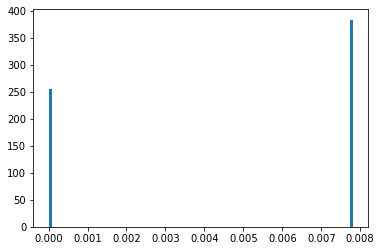

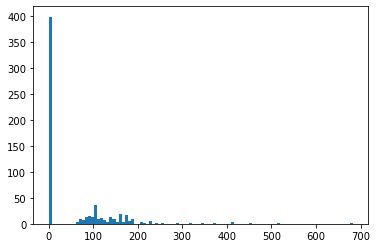

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10000668_0_0_0_float.hdf5


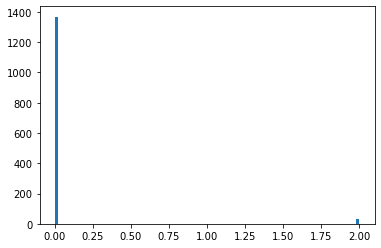

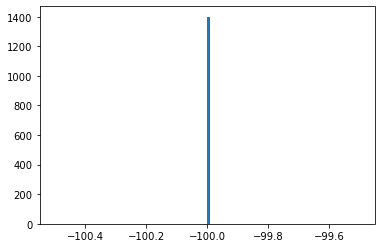

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6981523_0_0_0_float.hdf5


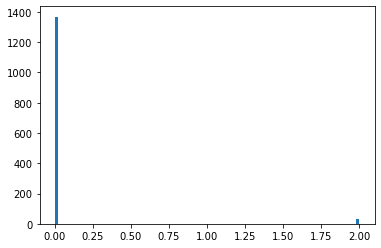

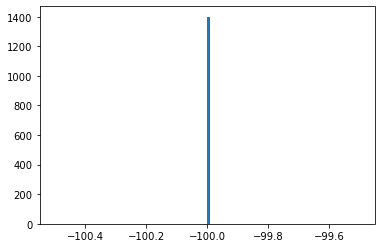

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a8515541_0_0_0_float.hdf5


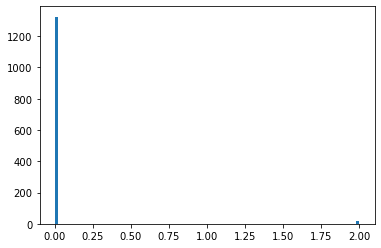

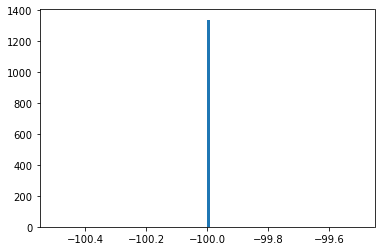

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13383679_3_2_0_float.hdf5


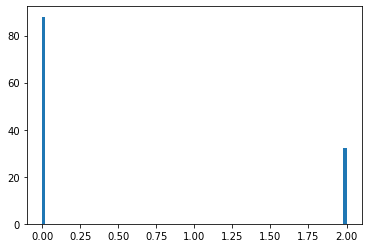

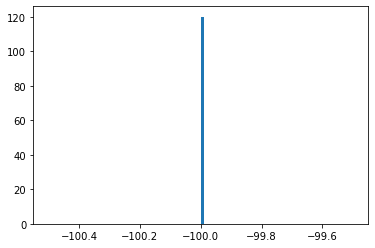

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6312225_3_1_0_float.hdf5


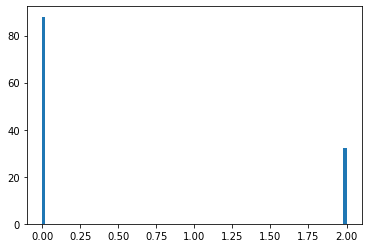

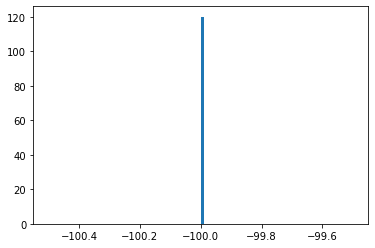

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a444662_2_1_1_float.hdf5


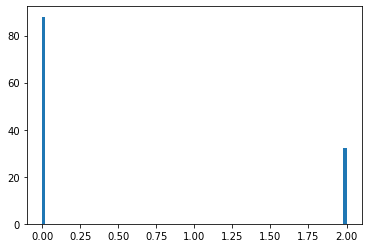

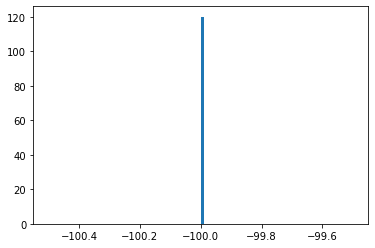

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11327158_2_3_1_float.hdf5


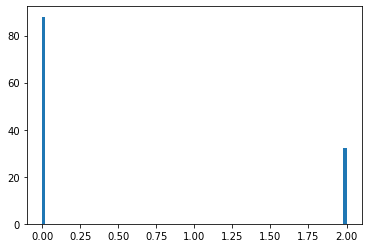

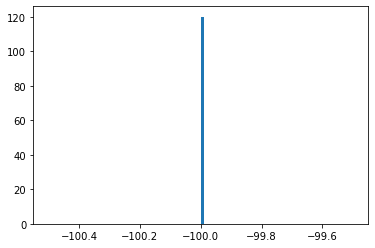

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12528590_0_3_0_float.hdf5


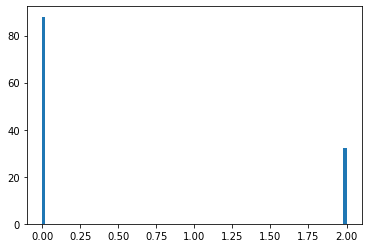

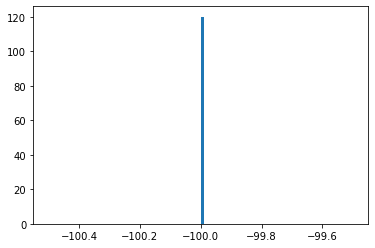

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2203550_1_0_2_float.hdf5


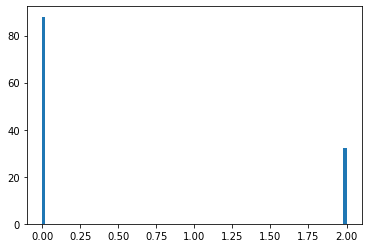

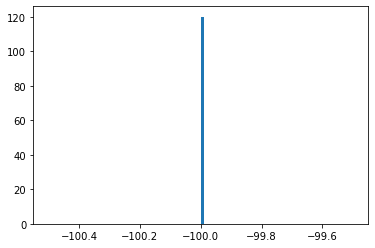

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1247205_0_0_3_float.hdf5


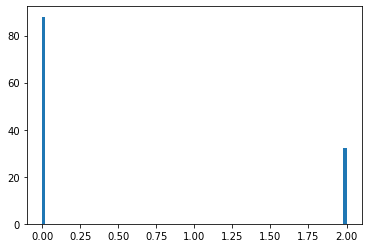

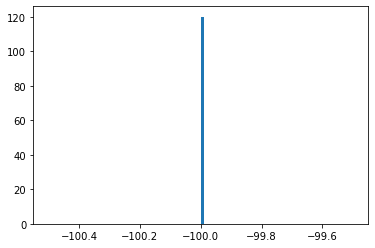

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14914341_3_0_3_float.hdf5


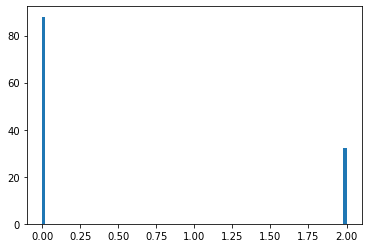

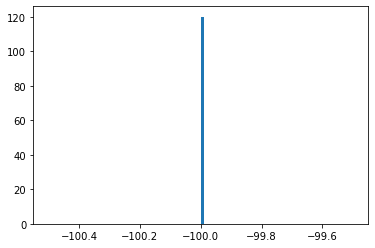

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1799235_1_3_2_float.hdf5


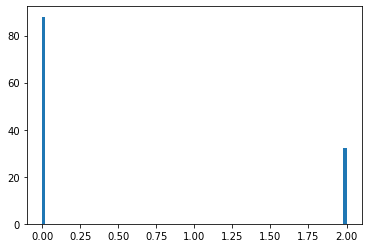

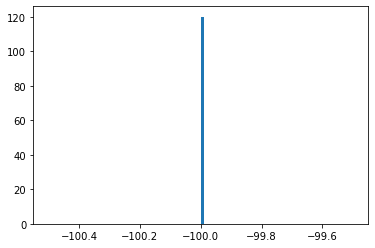

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6281891_0_2_3_float.hdf5


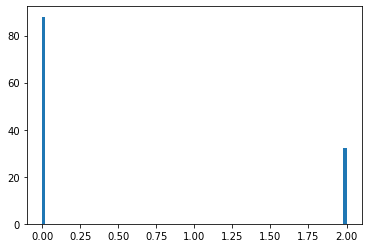

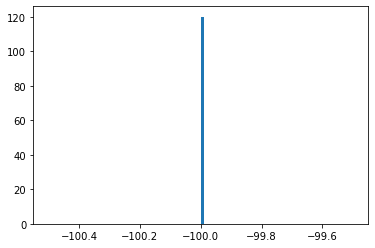

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2905575_2_3_0_float.hdf5


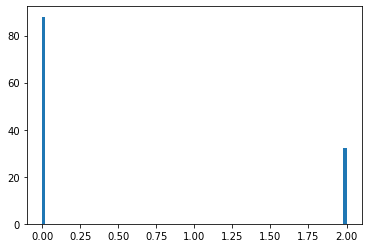

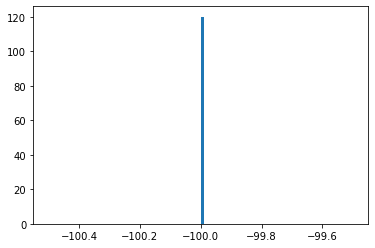

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10131921_1_3_0_float.hdf5


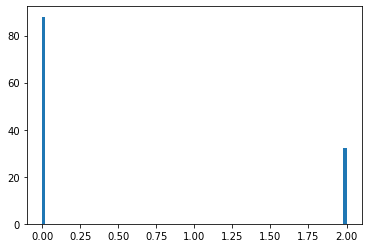

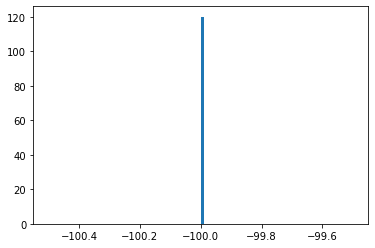

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12663761_2_2_1_float.hdf5


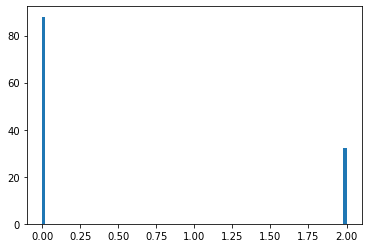

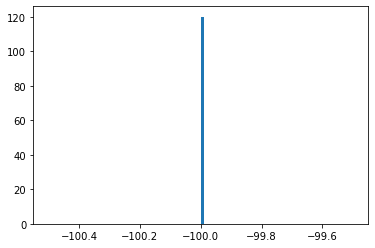

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a572689_3_3_0_float.hdf5


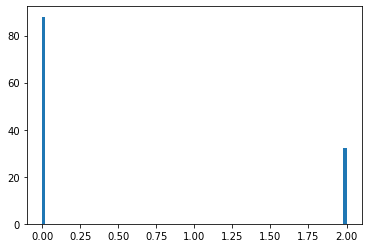

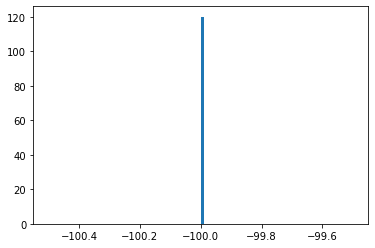

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14811255_2_1_1_float.hdf5


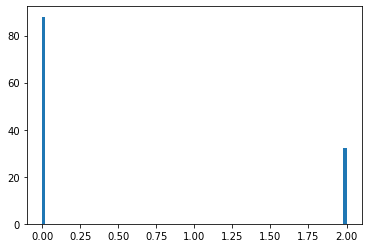

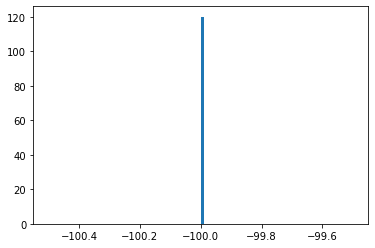

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3652763_2_2_0_float.hdf5


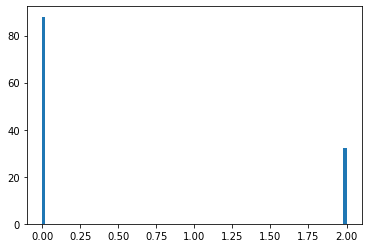

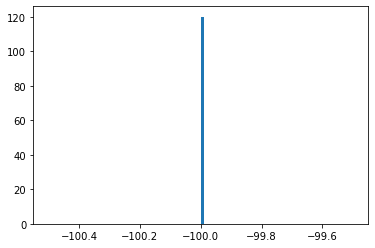

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2915047_1_3_3_float.hdf5


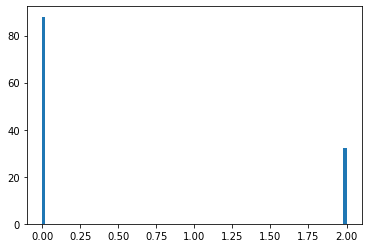

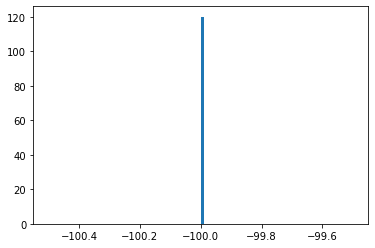

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12294615_3_2_3_float.hdf5


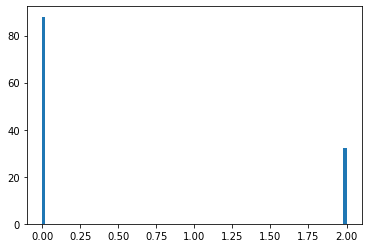

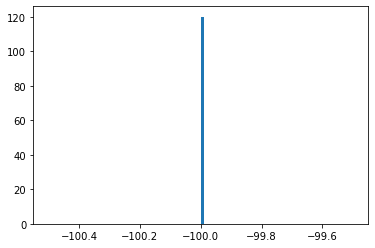

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2671315_2_0_2_float.hdf5


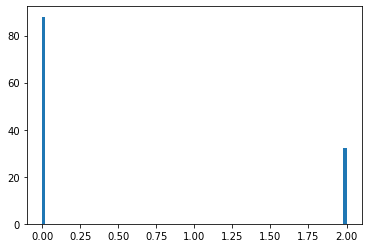

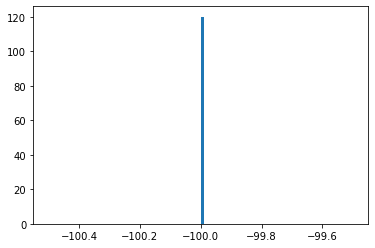

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13179063_1_3_2_float.hdf5


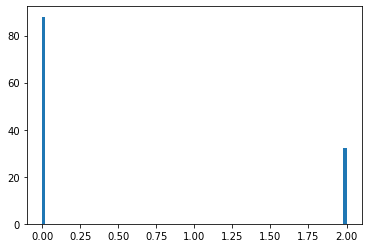

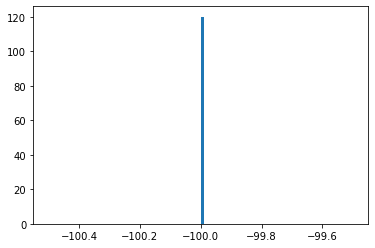

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14076581_0_2_0_float.hdf5


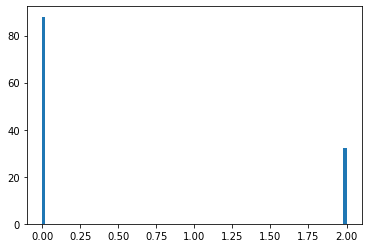

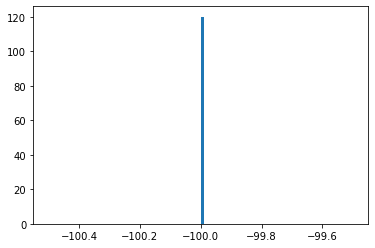

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15834683_2_3_2_float.hdf5


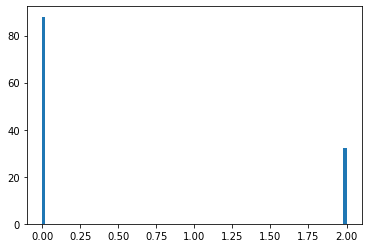

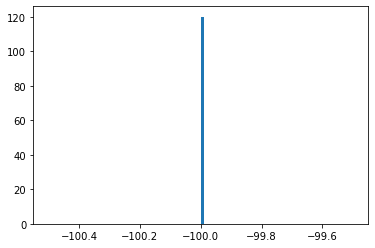

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13148935_0_1_1_float.hdf5


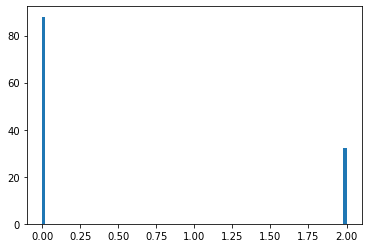

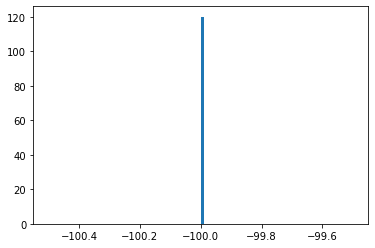

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3690247_1_2_1_float.hdf5


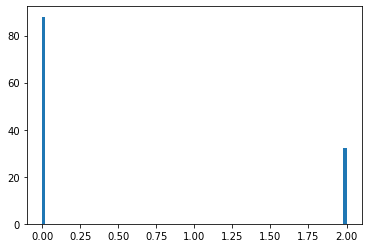

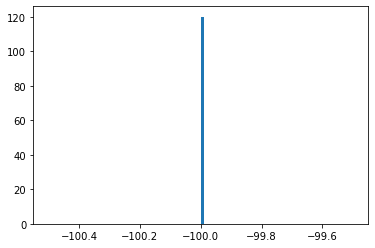

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13506648_3_1_1_float.hdf5


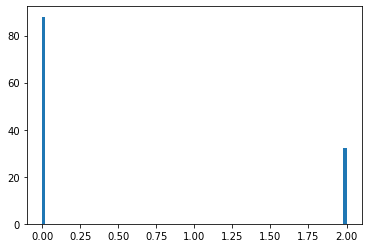

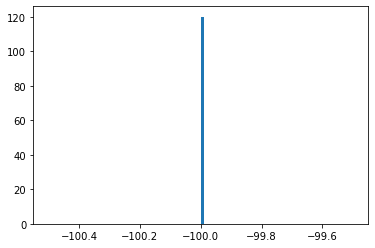

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13319522_1_0_1_float.hdf5


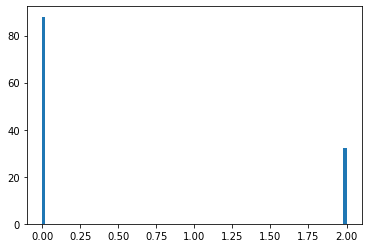

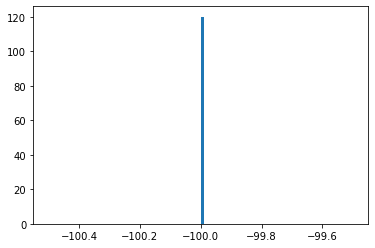

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14921288_2_3_1_float.hdf5


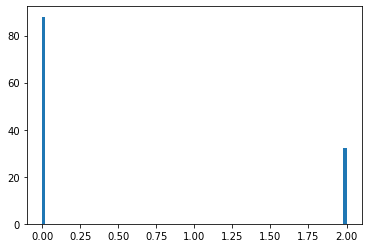

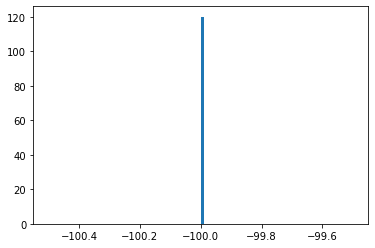

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16393290_0_1_3_float.hdf5


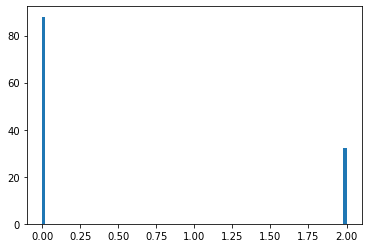

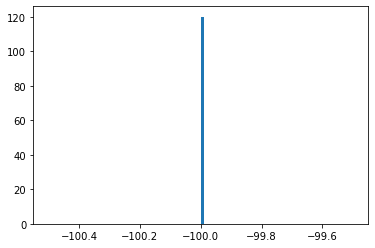

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4465621_3_3_1_float.hdf5


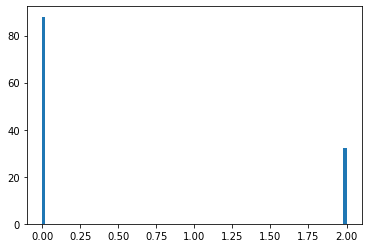

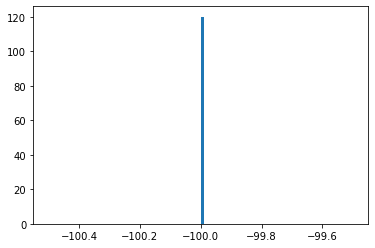

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13291891_2_1_0_float.hdf5


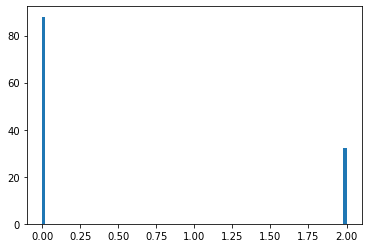

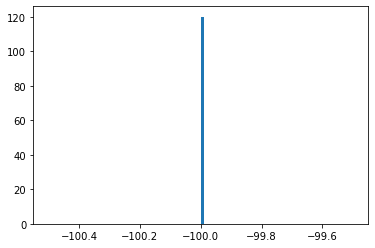

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12790580_1_3_1_float.hdf5


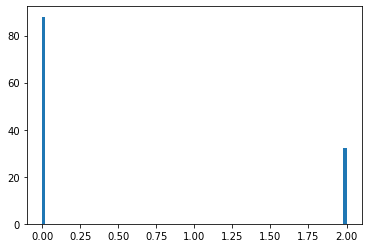

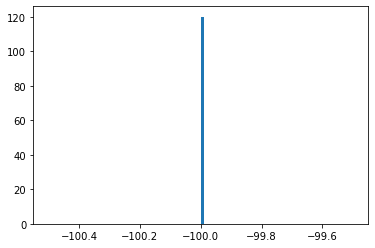

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3363772_2_2_0_float.hdf5


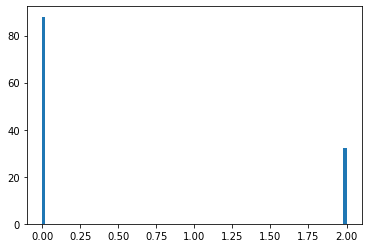

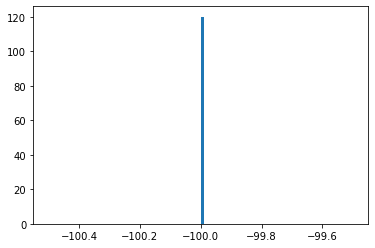

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13179063_0_3_2_float.hdf5


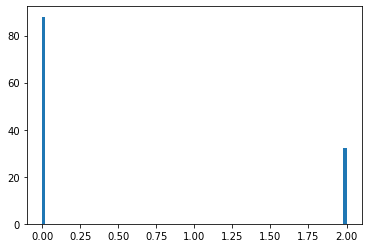

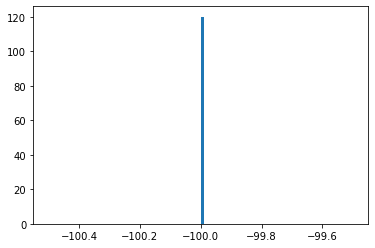

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11952311_3_3_3_float.hdf5


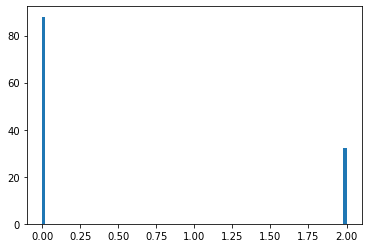

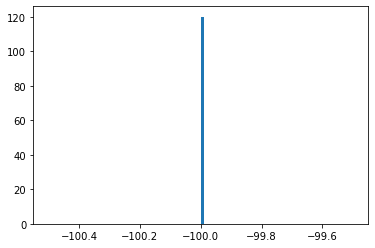

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5550606_0_2_2_float.hdf5


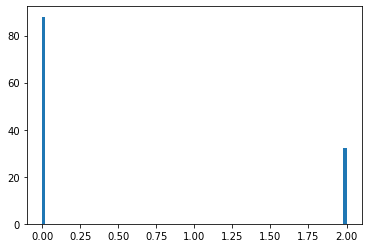

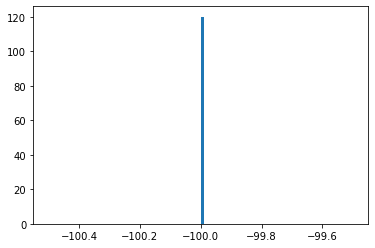

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6900240_3_3_2_float.hdf5


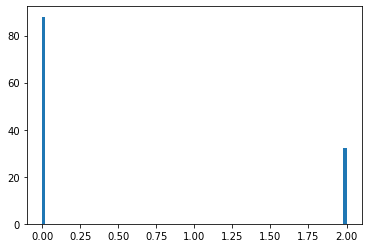

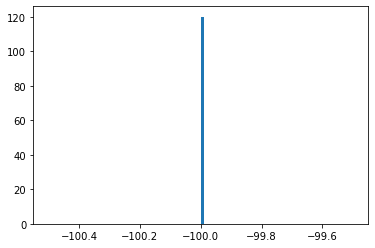

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6235854_3_1_0_float.hdf5


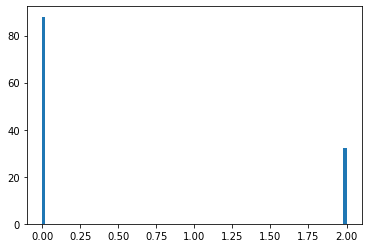

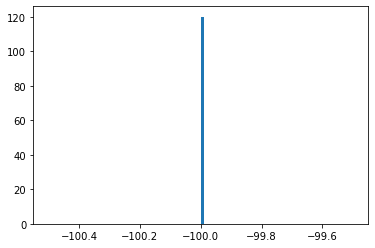

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6343427_3_1_1_float.hdf5


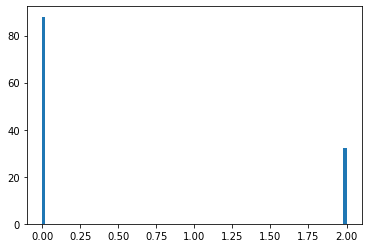

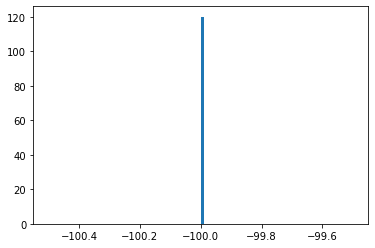

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a413623_1_0_0_float.hdf5


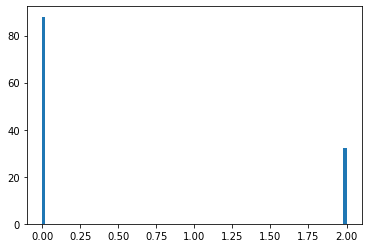

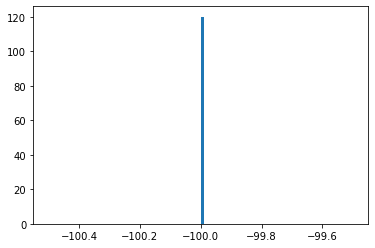

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13201448_3_2_0_float.hdf5


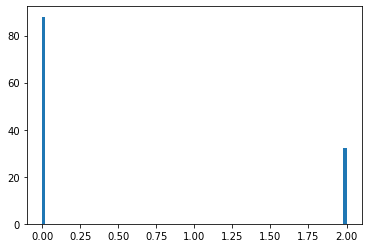

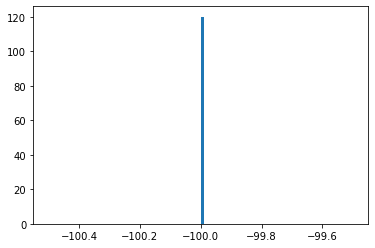

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2766630_3_2_2_float.hdf5


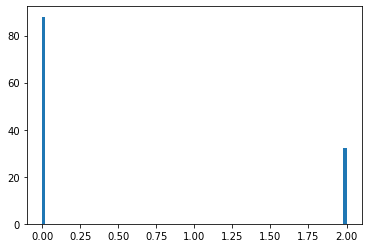

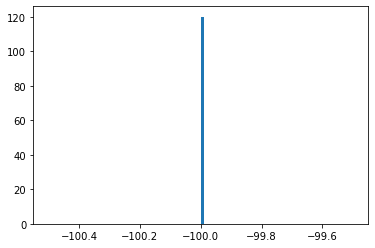

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11861240_2_0_1_float.hdf5


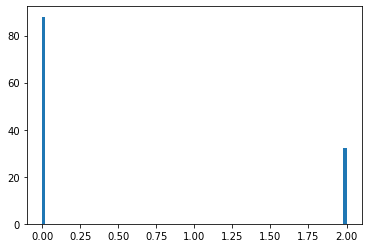

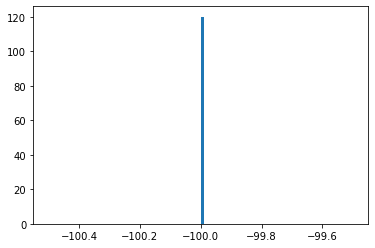

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14140796_3_2_0_float.hdf5


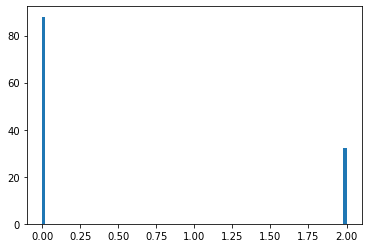

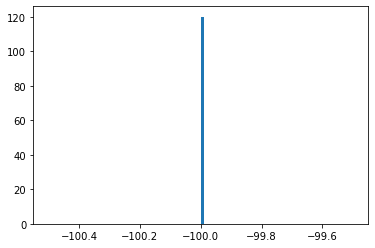

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15087358_1_2_2_float.hdf5


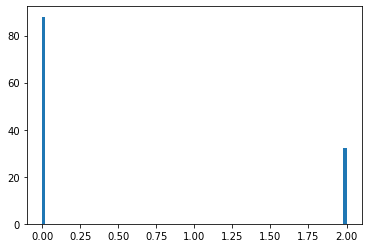

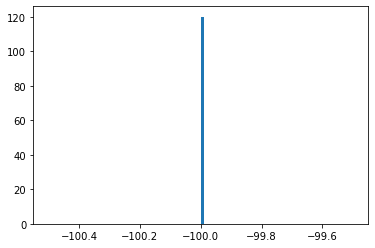

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16681114_3_3_2_float.hdf5


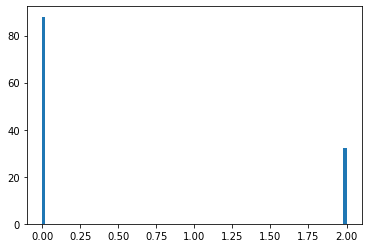

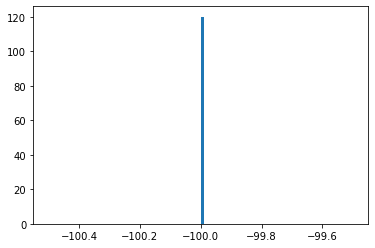

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6776813_0_3_2_float.hdf5


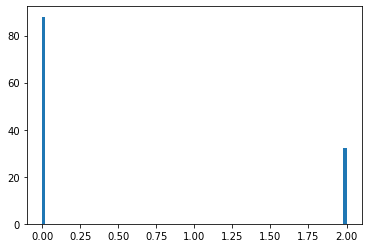

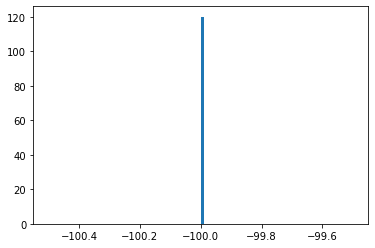

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12659300_1_0_2_float.hdf5


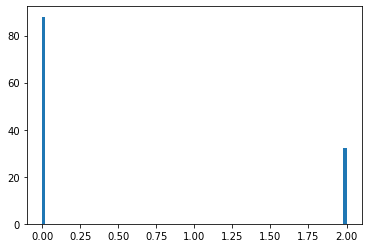

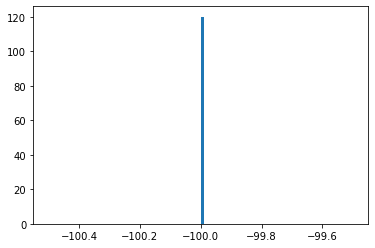

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16627071_1_1_1_float.hdf5


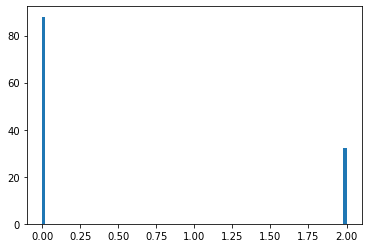

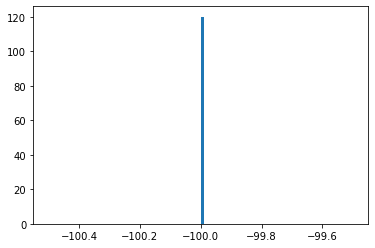

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1570076_1_0_0_float.hdf5


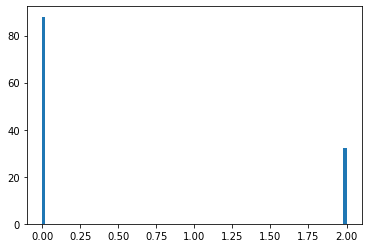

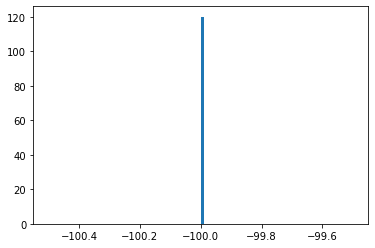

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5933743_0_2_2_float.hdf5


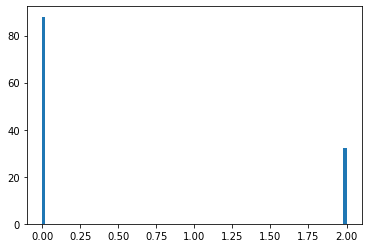

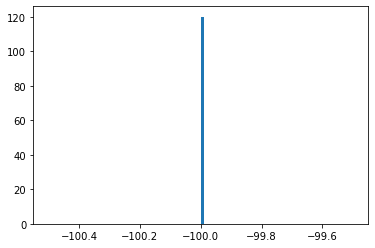

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1702282_3_1_3_float.hdf5


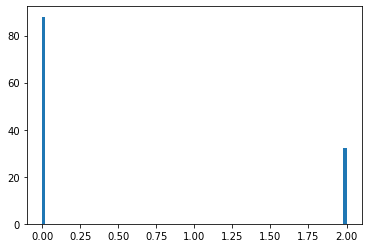

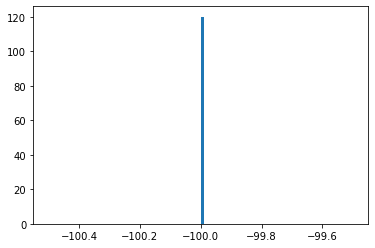

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16767807_2_0_2_float.hdf5


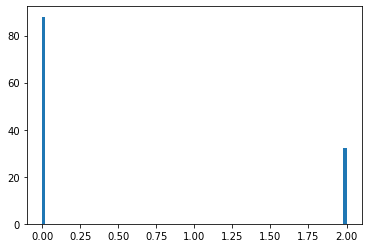

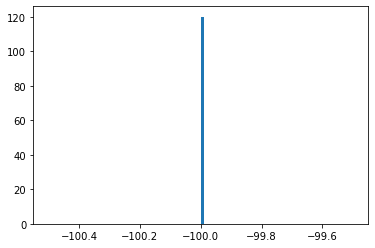

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10032141_3_3_1_float.hdf5


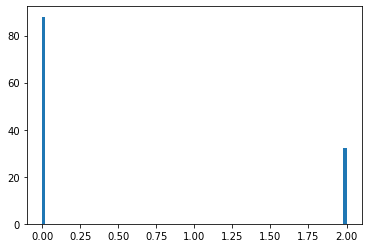

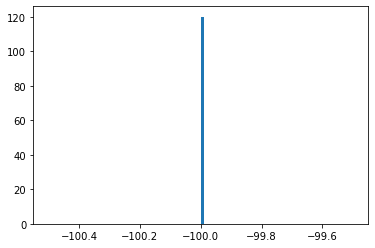

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2416285_0_1_3_float.hdf5


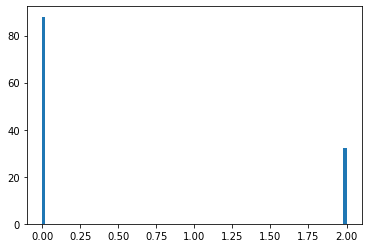

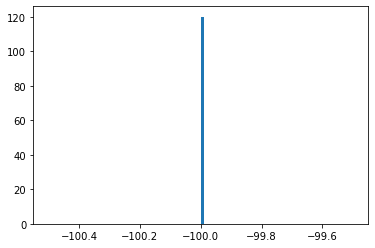

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2952175_2_1_2_float.hdf5


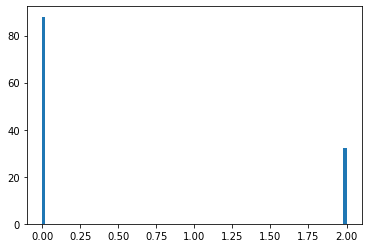

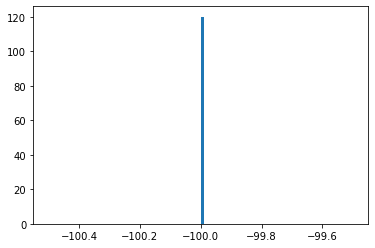

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3615299_3_2_2_float.hdf5


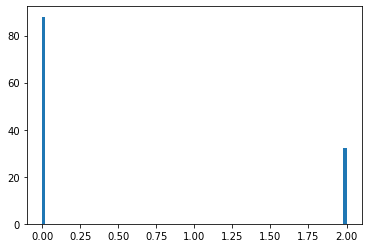

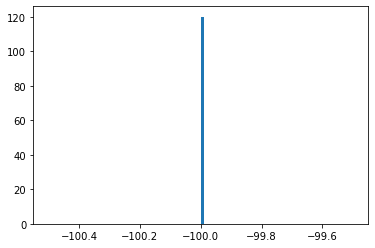

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5513339_1_2_2_float.hdf5


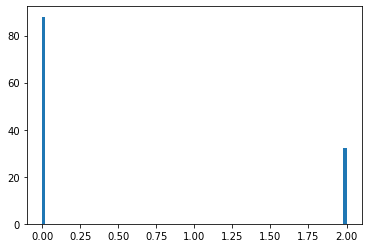

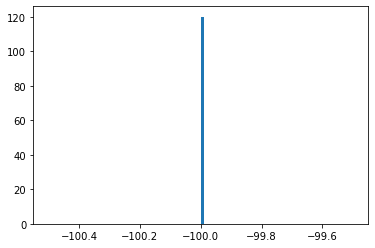

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14831531_1_2_1_float.hdf5


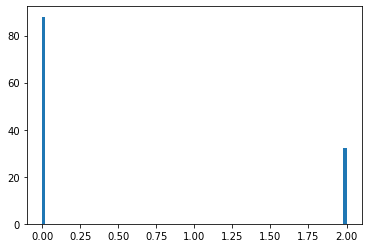

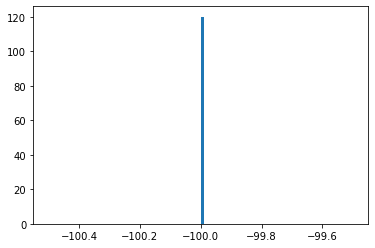

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12330502_3_2_2_float.hdf5


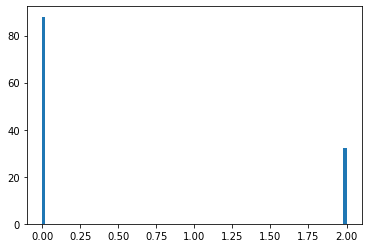

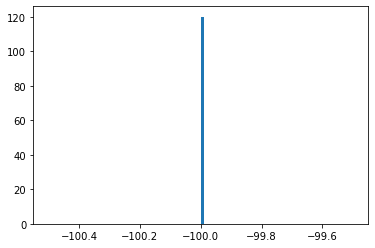

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14965258_1_0_1_float.hdf5


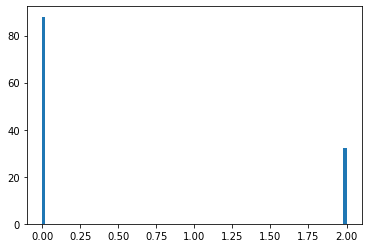

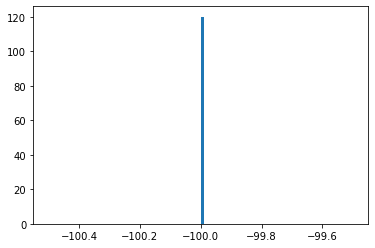

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13349234_1_3_1_float.hdf5


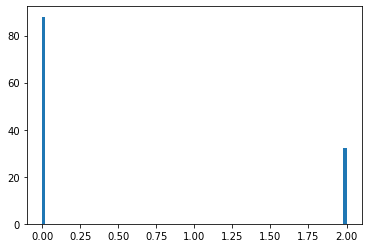

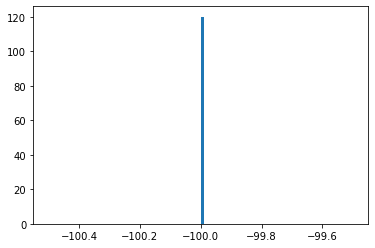

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4732358_1_0_2_float.hdf5


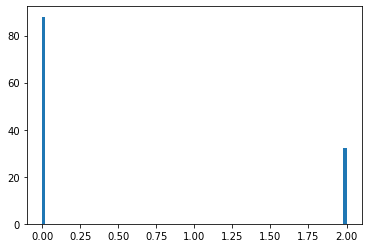

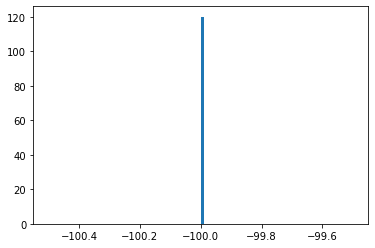

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15714011_2_0_1_float.hdf5


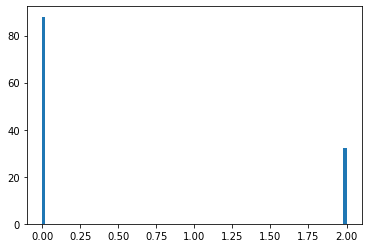

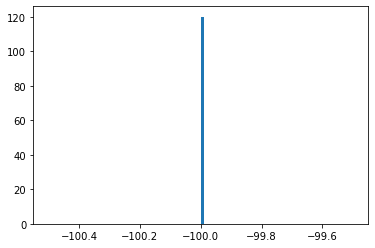

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2412060_1_3_3_float.hdf5


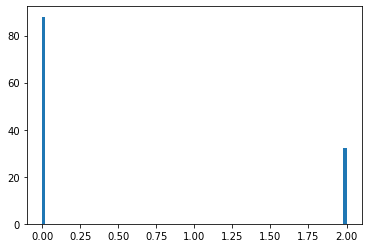

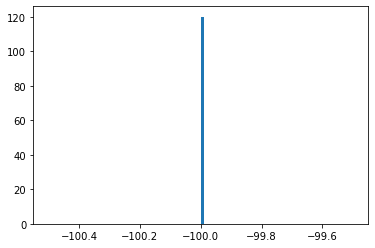

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3713426_1_1_1_float.hdf5


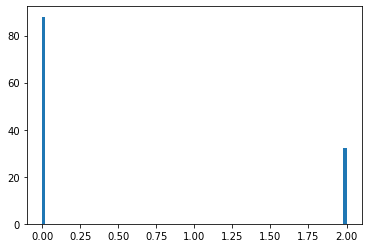

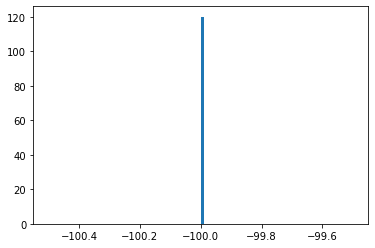

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5002559_1_2_3_float.hdf5


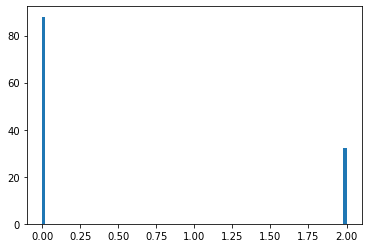

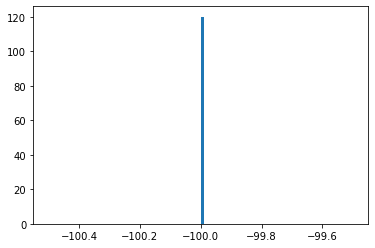

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2445426_3_3_2_float.hdf5


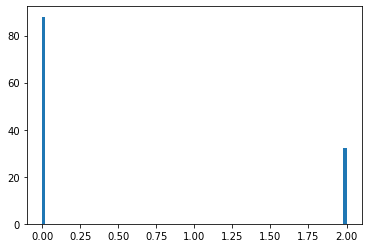

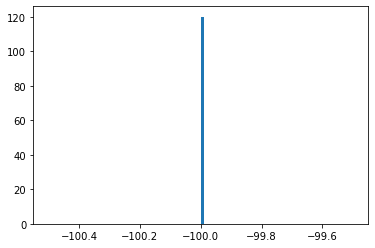

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6863086_2_2_1_float.hdf5


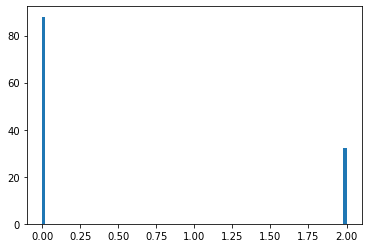

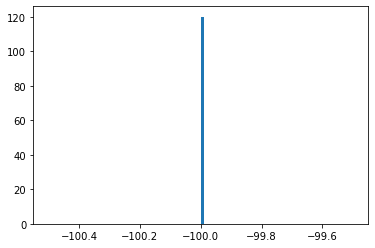

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5245828_3_0_3_float.hdf5


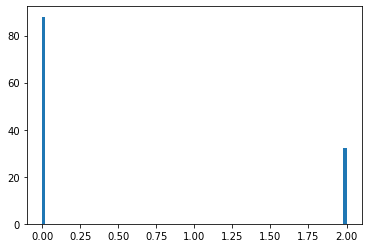

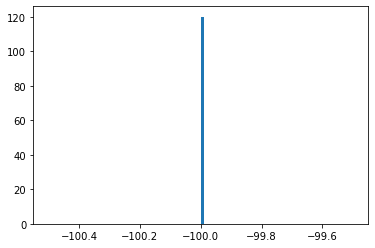

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16031116_1_2_0_float.hdf5


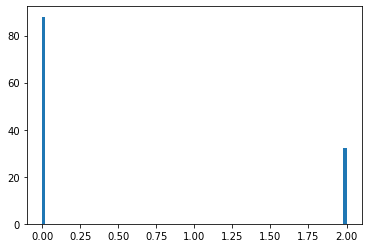

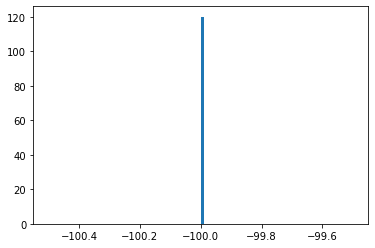

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3837086_3_1_2_float.hdf5


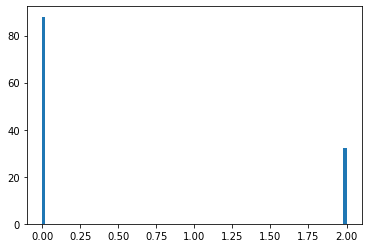

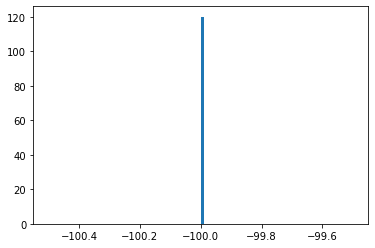

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11834333_3_2_1_float.hdf5


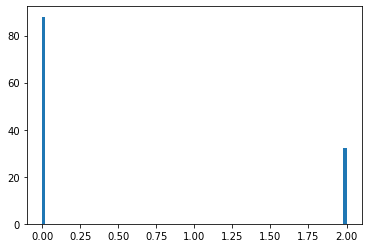

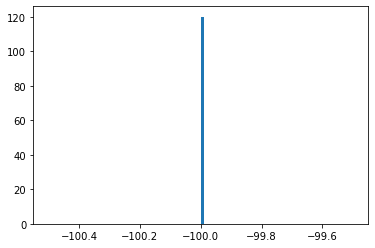

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16689903_2_2_1_float.hdf5


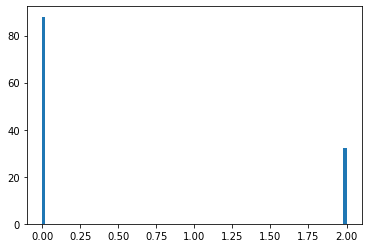

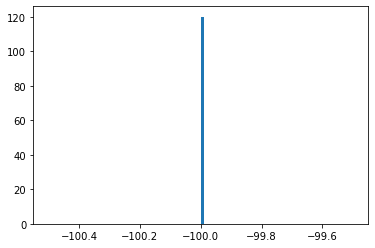

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15954756_2_2_3_float.hdf5


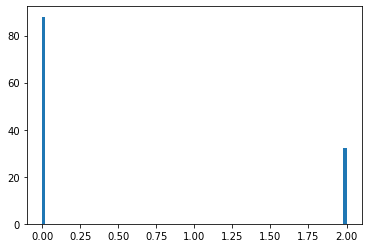

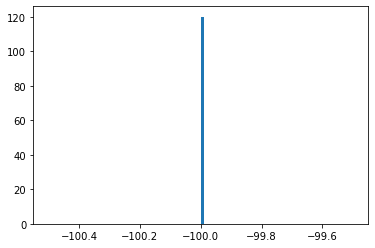

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16397651_1_3_1_float.hdf5


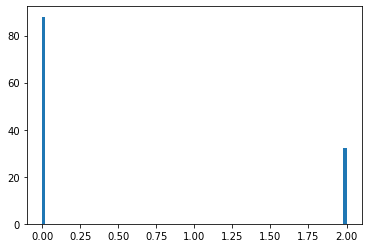

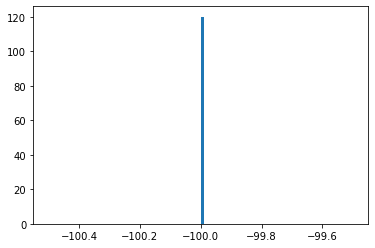

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5263184_2_1_3_float.hdf5


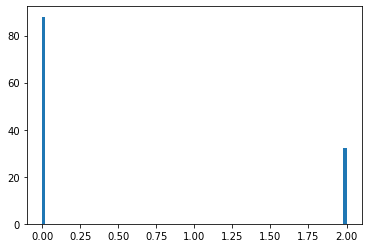

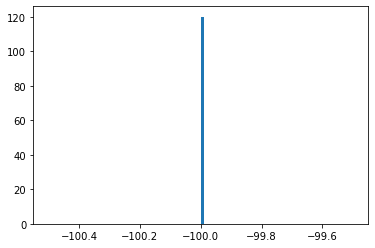

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16246388_0_1_2_float.hdf5


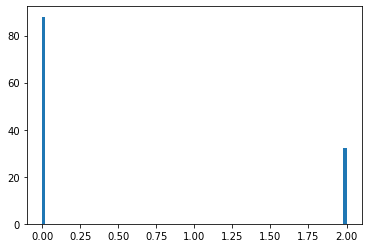

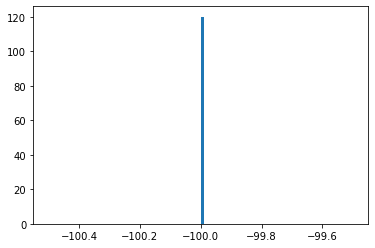

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5462888_2_0_3_float.hdf5


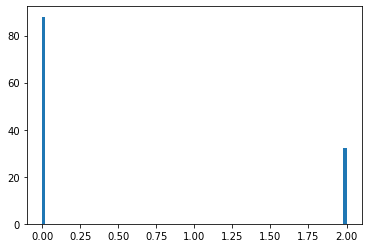

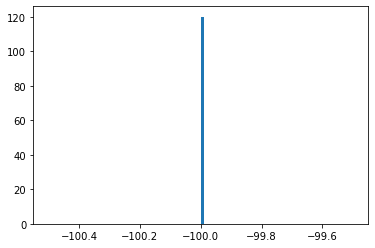

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3200017_1_3_3_float.hdf5


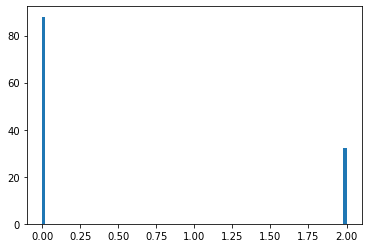

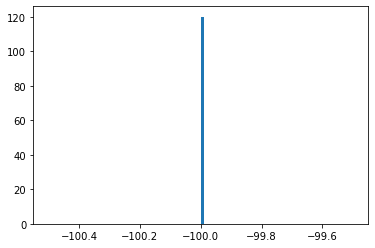

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12239741_2_1_1_float.hdf5


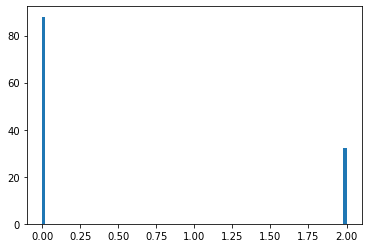

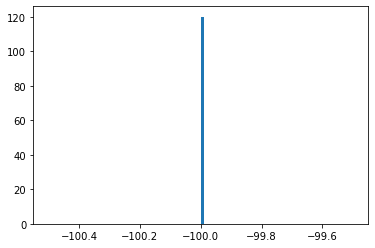

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15462905_0_0_0_float.hdf5


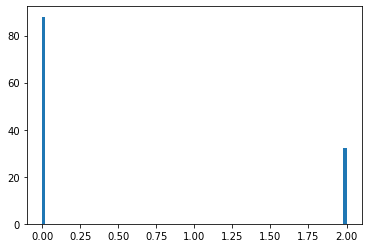

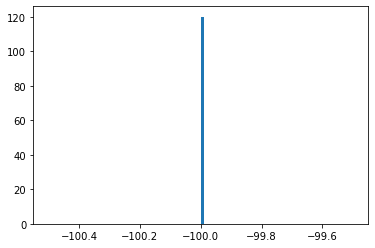

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4513834_3_2_2_float.hdf5


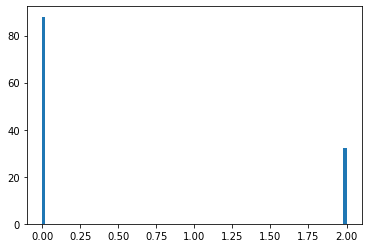

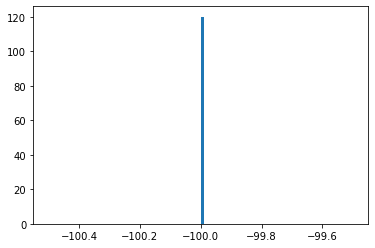

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5150041_3_0_0_float.hdf5


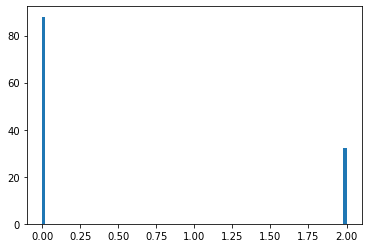

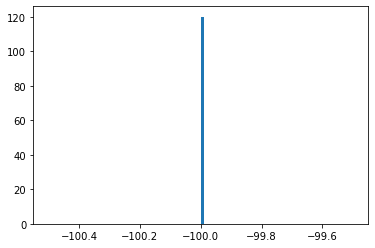

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16175495_2_0_0_float.hdf5


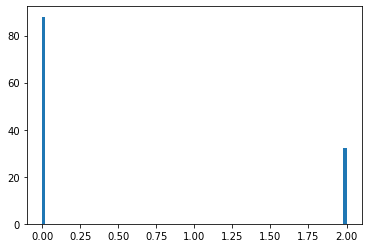

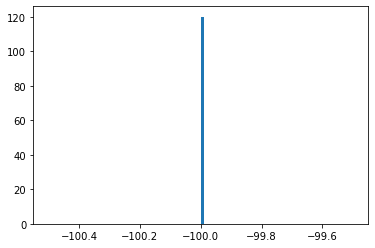

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14533019_1_0_1_float.hdf5


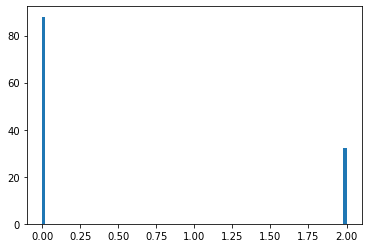

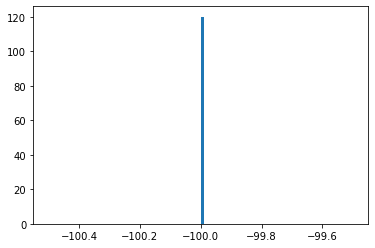

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16480498_1_2_2_float.hdf5


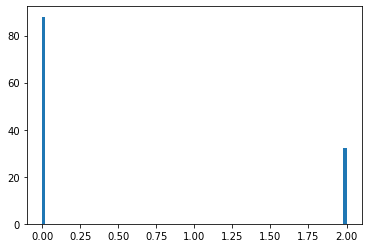

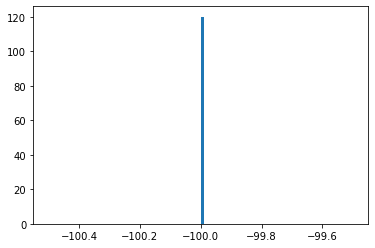

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16034771_2_0_3_float.hdf5


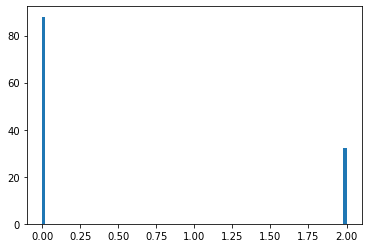

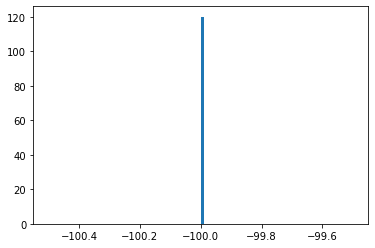

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2225335_2_3_0_float.hdf5


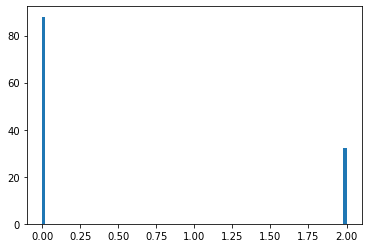

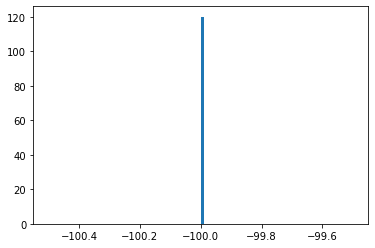

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13349234_1_2_1_float.hdf5


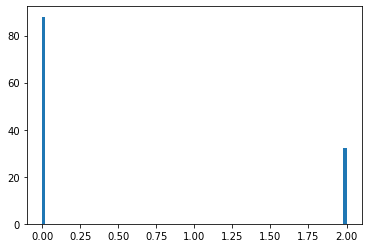

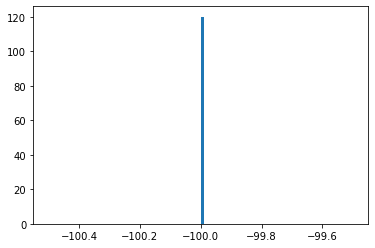

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10806786_1_2_0_float.hdf5


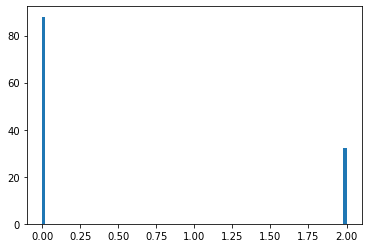

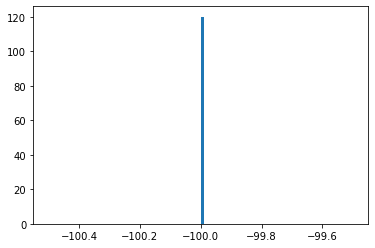

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3201029_1_3_0_float.hdf5


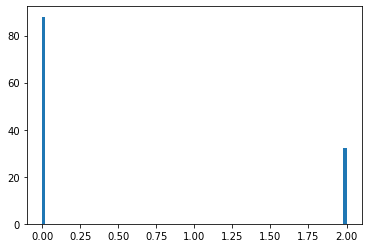

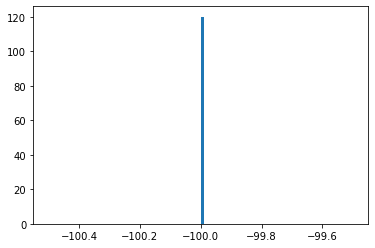

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3366356_1_1_2_float.hdf5


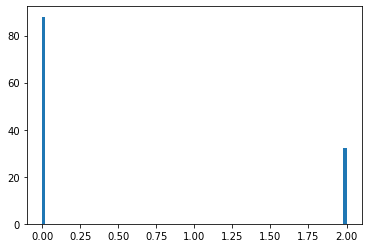

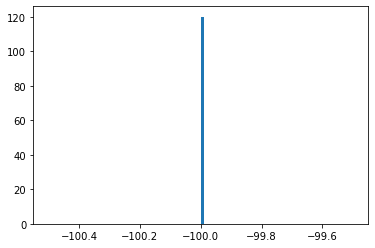

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4781528_1_1_3_float.hdf5


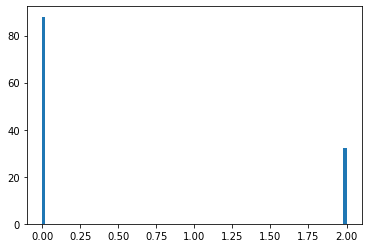

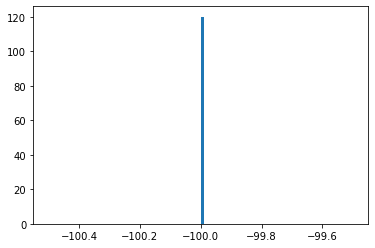

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5294635_2_1_3_float.hdf5


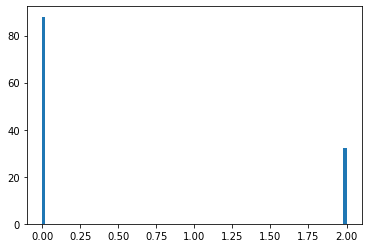

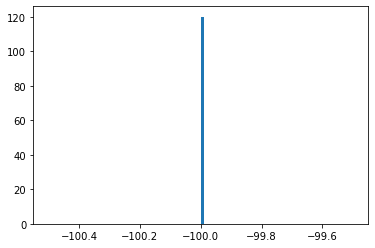

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13820835_1_2_0_float.hdf5


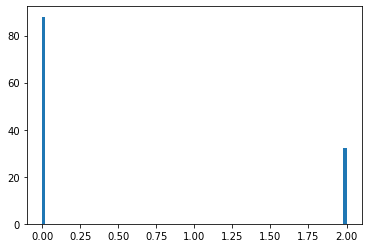

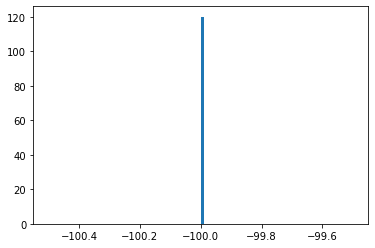

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15616599_3_0_1_float.hdf5


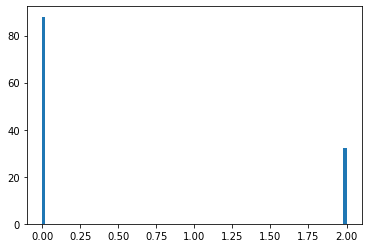

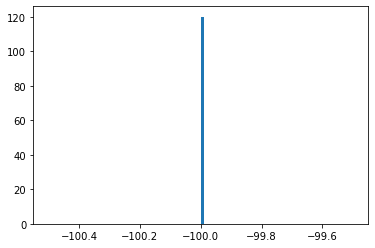

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13988645_2_0_3_float.hdf5


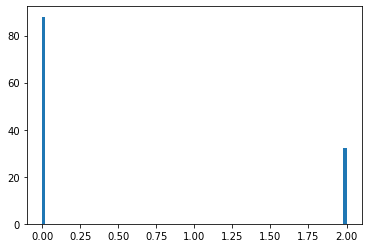

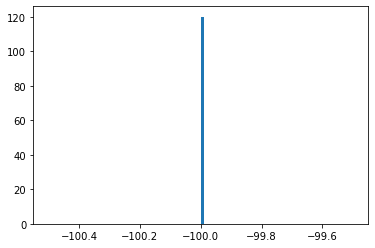

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10105661_1_1_0_float.hdf5


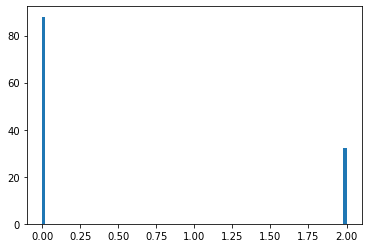

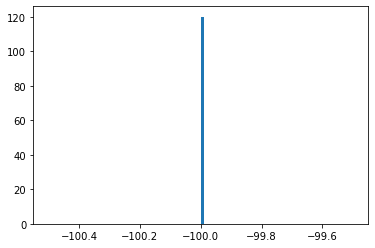

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1347105_1_1_1_float.hdf5


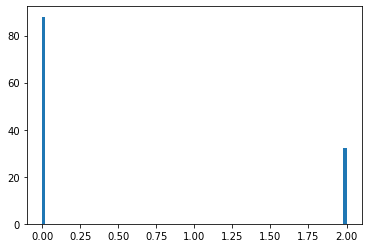

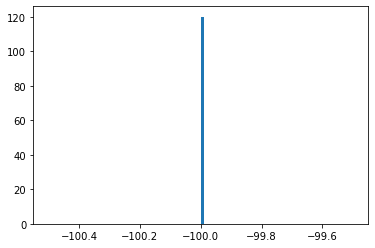

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a659335_0_3_3_float.hdf5


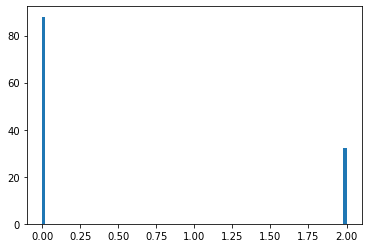

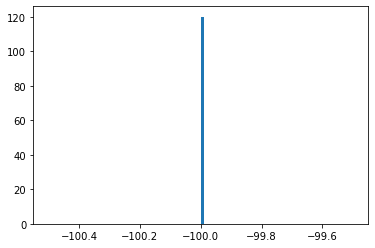

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4132673_2_0_1_float.hdf5


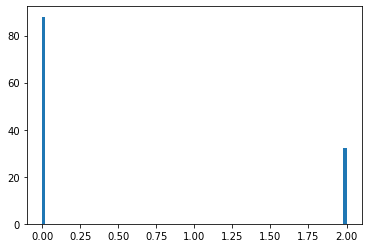

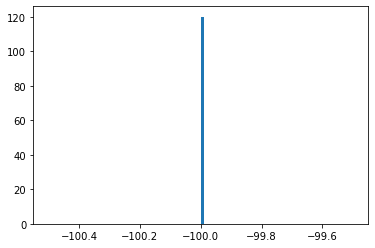

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4188226_1_2_0_float.hdf5


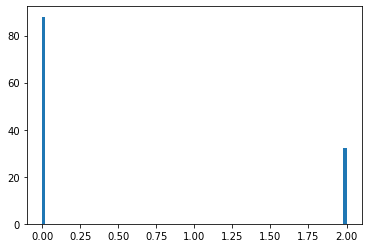

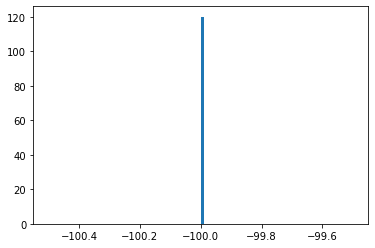

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4713276_2_2_2_float.hdf5


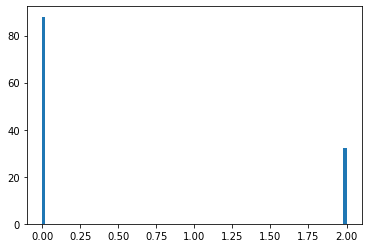

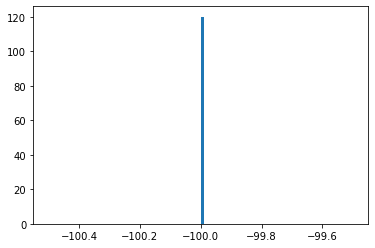

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6796500_0_3_3_float.hdf5


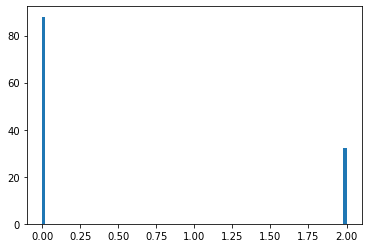

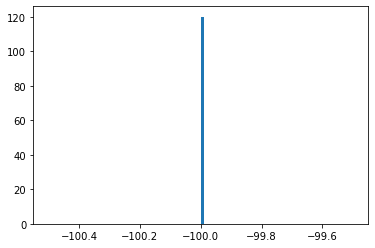

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10964484_2_3_0_float.hdf5


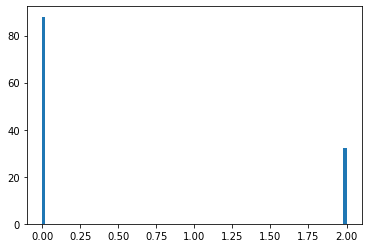

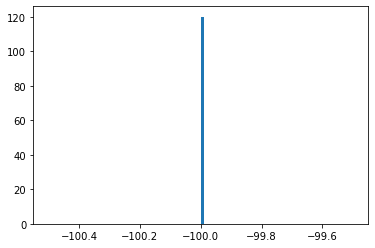

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16138256_1_3_2_float.hdf5


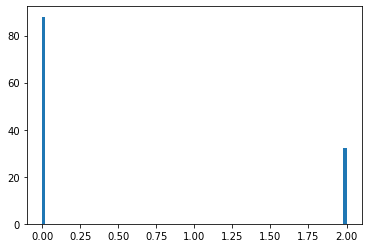

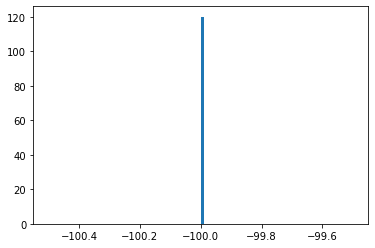

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15209654_0_1_0_float.hdf5


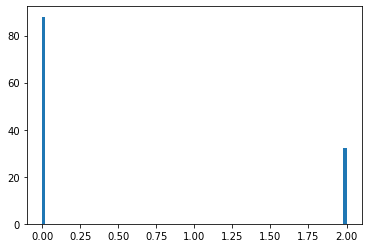

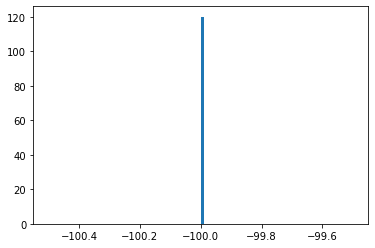

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13789102_3_0_1_float.hdf5


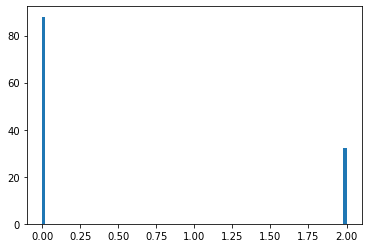

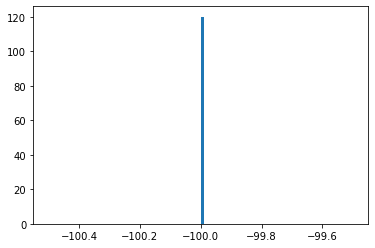

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14894097_0_3_3_float.hdf5


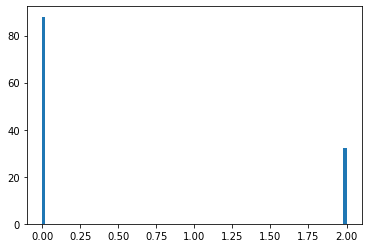

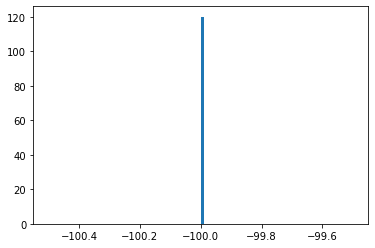

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a152056_1_0_1_float.hdf5


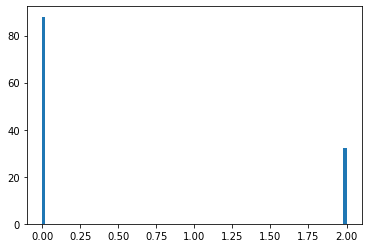

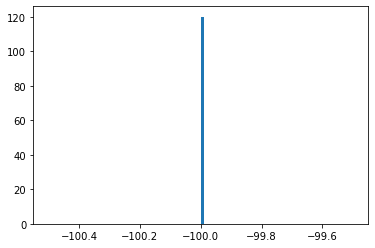

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1958959_2_3_1_float.hdf5


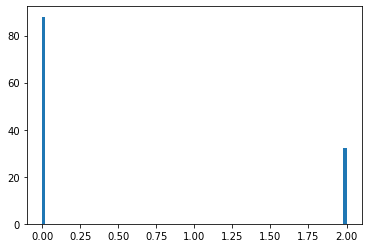

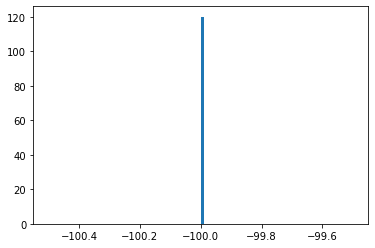

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15136671_3_2_0_float.hdf5


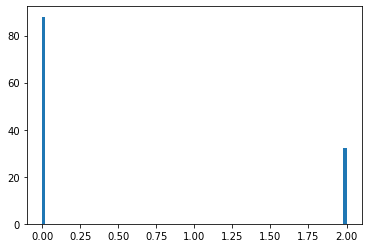

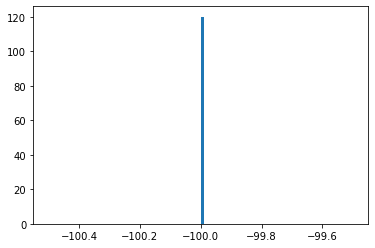

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3958629_3_1_2_float.hdf5


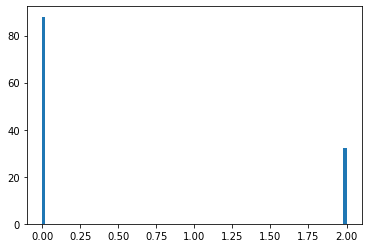

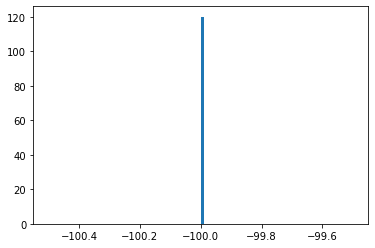

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12578966_2_2_0_float.hdf5


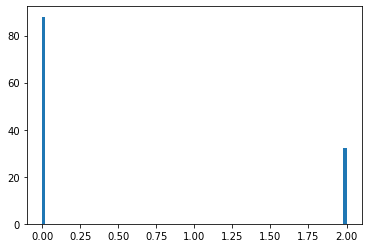

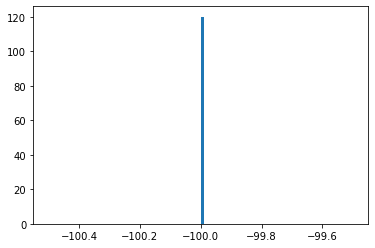

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4297945_0_0_2_float.hdf5


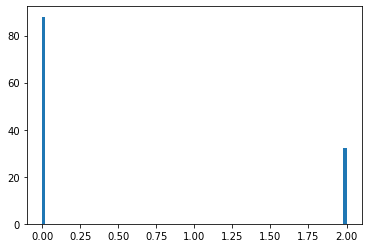

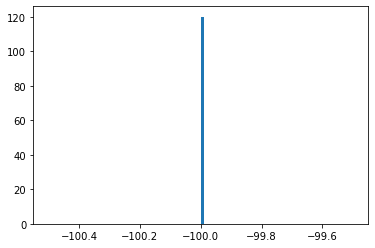

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3336289_3_3_2_float.hdf5


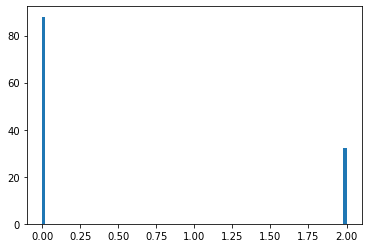

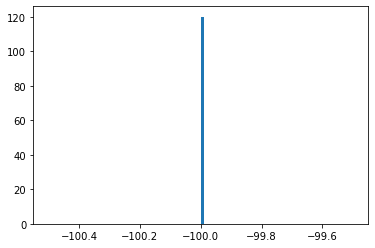

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5575357_0_3_1_float.hdf5


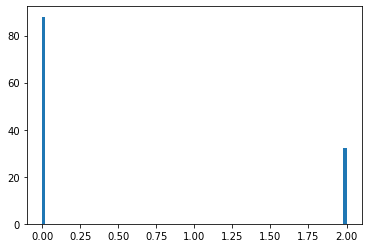

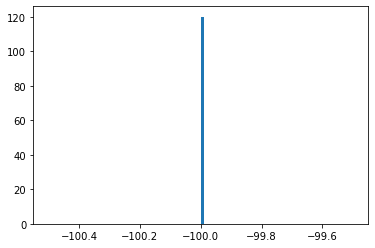

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5993872_2_1_1_float.hdf5


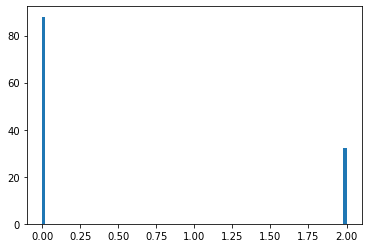

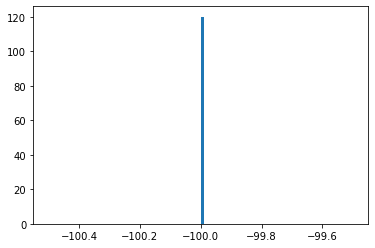

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5390892_2_0_2_float.hdf5


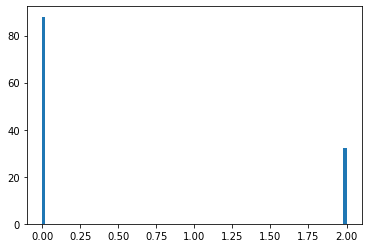

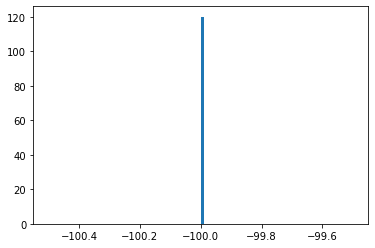

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12331660_2_3_2_float.hdf5


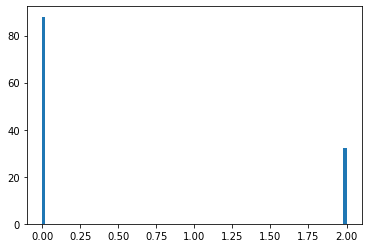

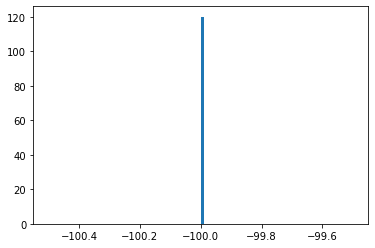

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10420725_1_2_3_float.hdf5


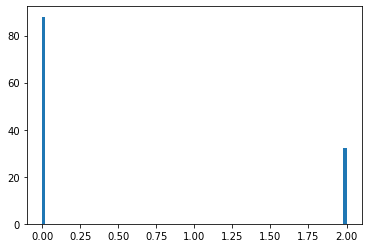

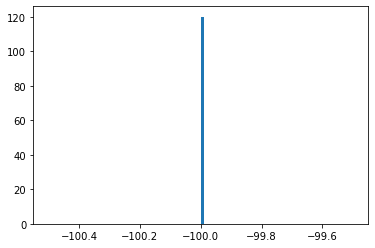

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1344752_2_2_0_float.hdf5


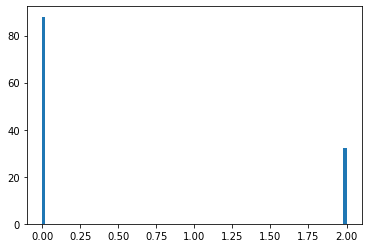

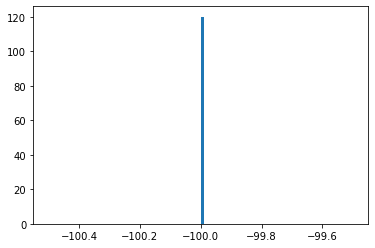

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4859265_3_2_1_float.hdf5


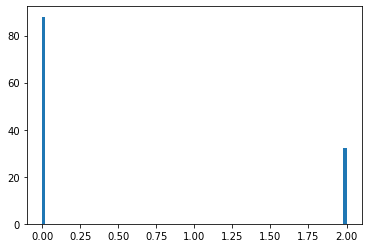

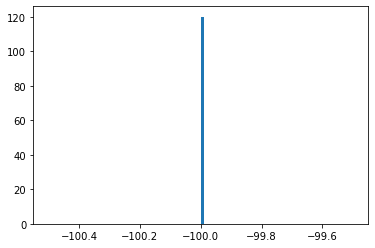

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2671316_3_0_1_float.hdf5


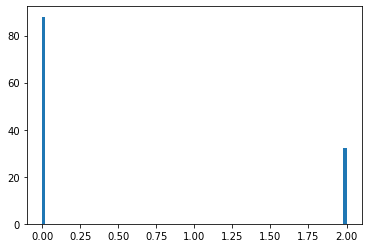

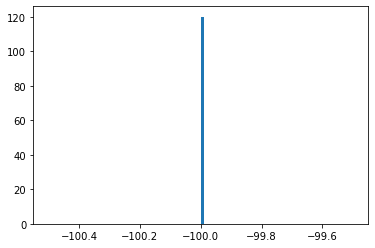

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3427730_0_2_3_float.hdf5


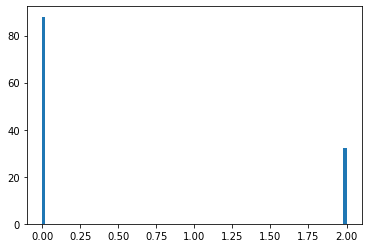

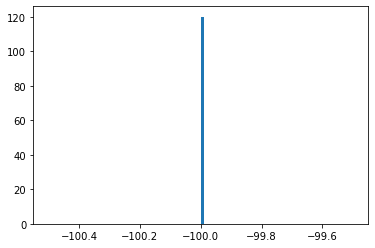

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16412510_0_0_2_float.hdf5


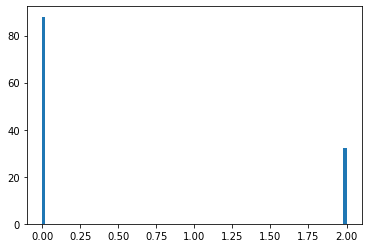

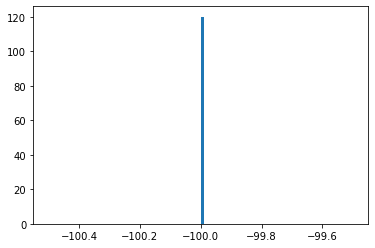

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15984588_1_0_1_float.hdf5


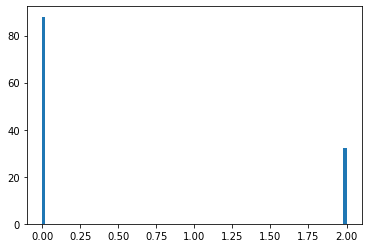

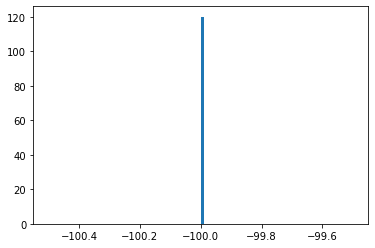

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12980342_2_0_0_float.hdf5


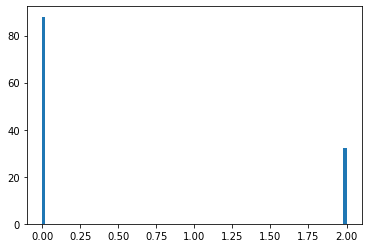

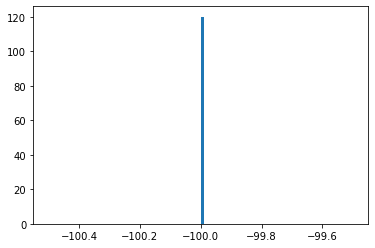

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4682034_2_3_3_float.hdf5


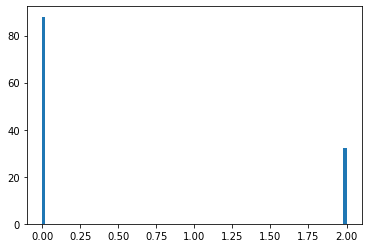

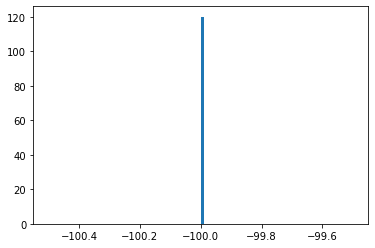

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1842538_2_2_0_float.hdf5


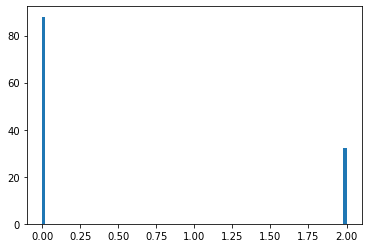

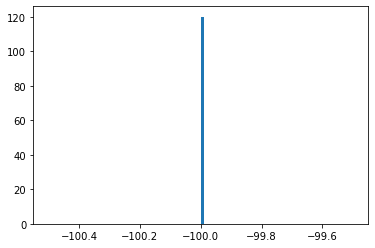

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5797974_2_0_3_float.hdf5


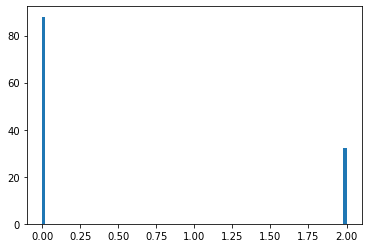

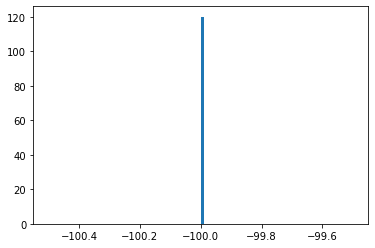

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15005272_2_1_1_float.hdf5


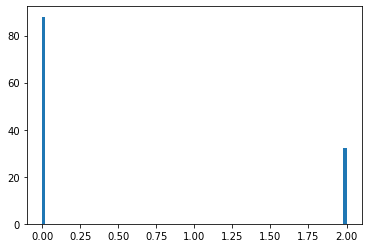

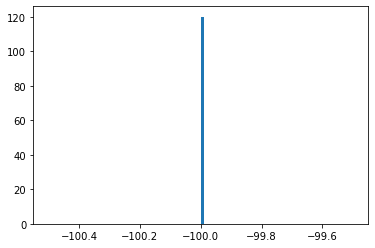

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6733523_2_2_0_float.hdf5


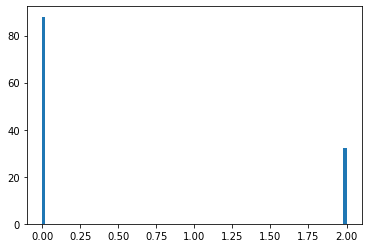

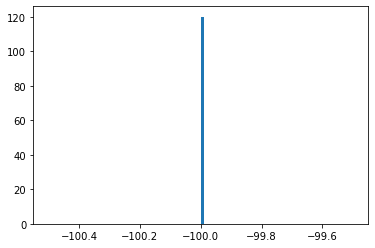

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a298409_2_0_3_float.hdf5


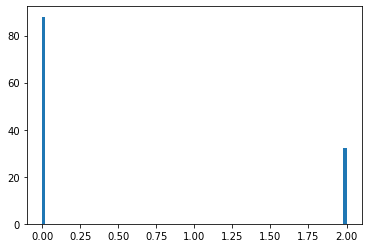

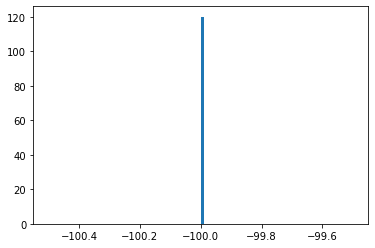

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12294615_3_0_1_float.hdf5


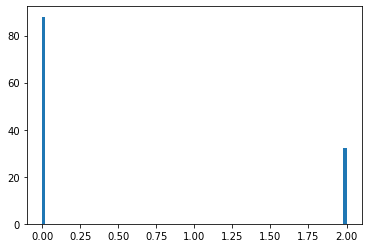

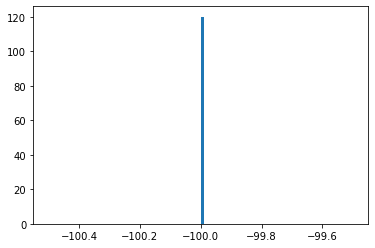

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13557843_3_1_1_float.hdf5


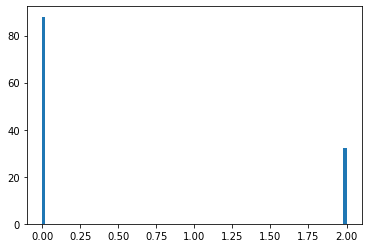

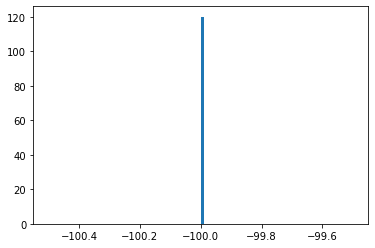

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10677512_0_0_0_float.hdf5


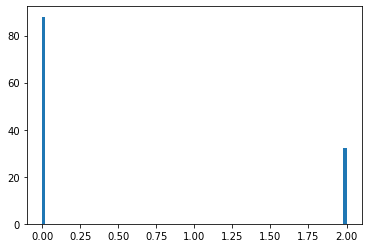

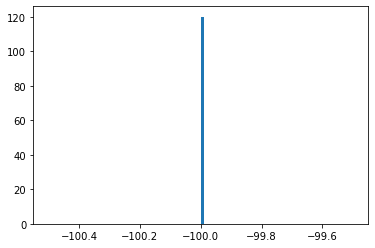

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16354833_3_2_2_float.hdf5


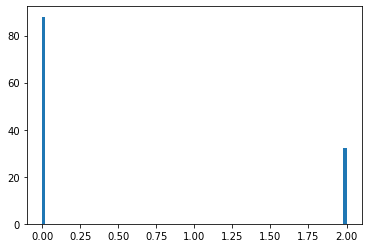

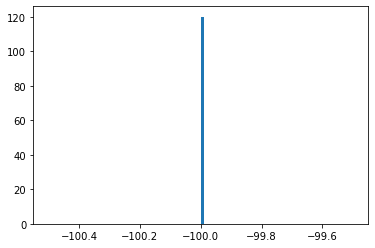

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4669778_3_3_2_float.hdf5


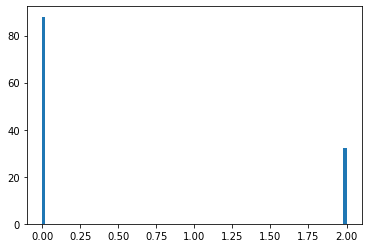

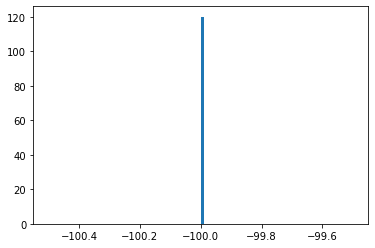

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1651170_2_1_3_float.hdf5


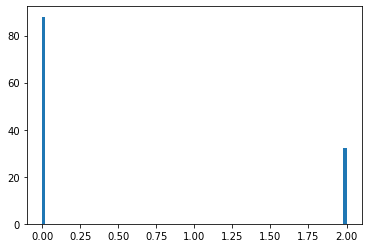

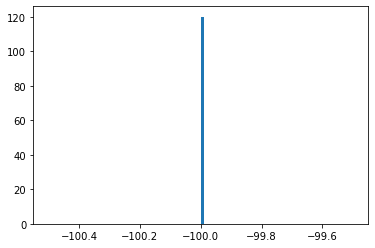

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5796531_3_2_1_float.hdf5


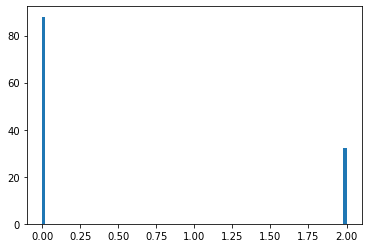

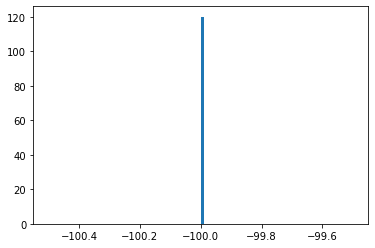

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14038682_1_0_2_float.hdf5


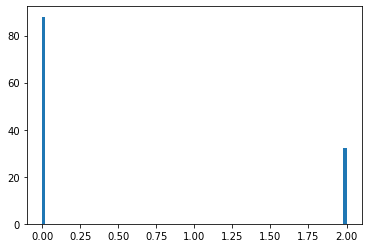

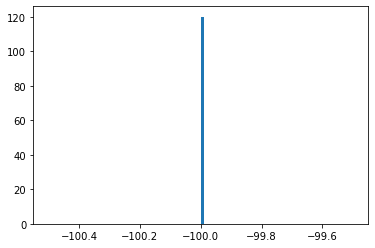

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1046697_0_2_3_float.hdf5


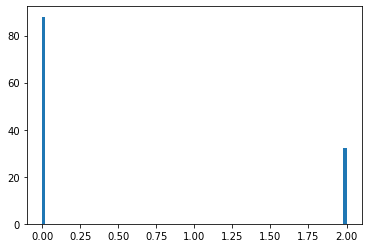

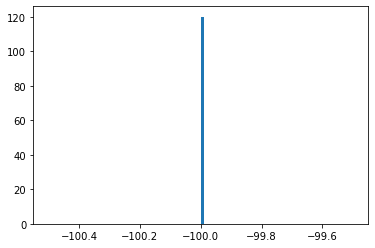

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2030675_3_2_0_float.hdf5


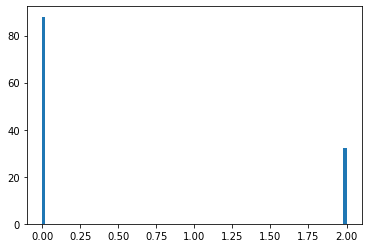

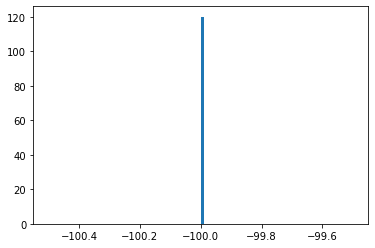

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11188835_3_1_2_float.hdf5


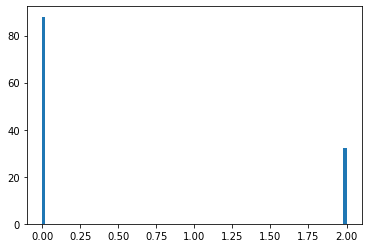

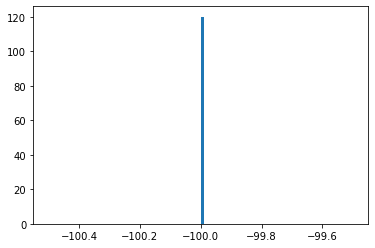

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2533141_3_1_2_float.hdf5


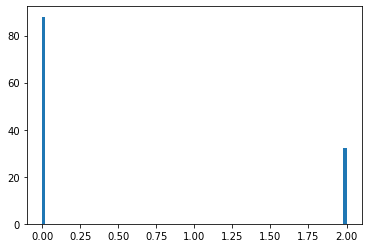

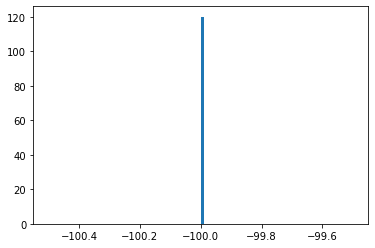

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11751445_1_2_0_float.hdf5


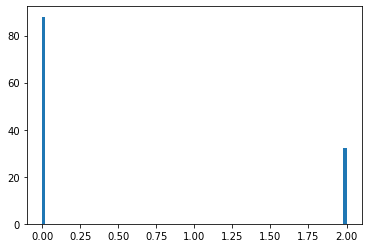

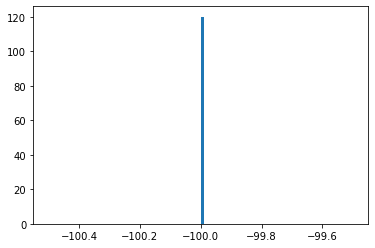

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6929192_0_1_1_float.hdf5


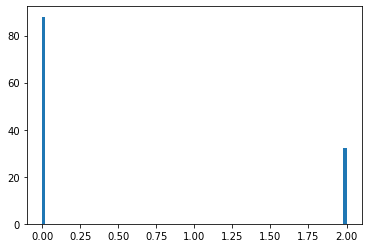

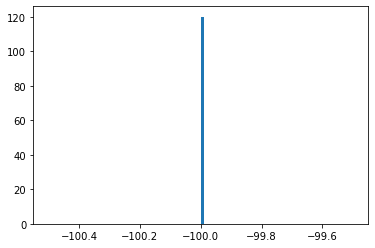

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1082763_1_1_3_float.hdf5


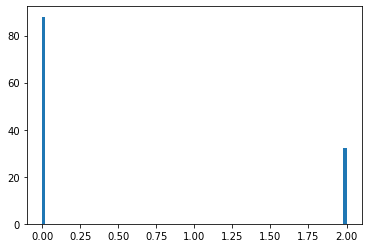

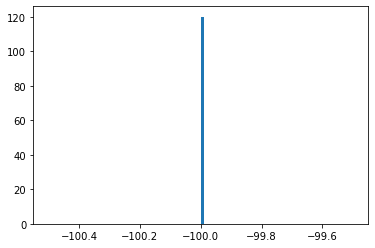

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14762792_1_3_3_float.hdf5


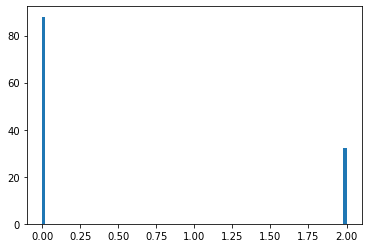

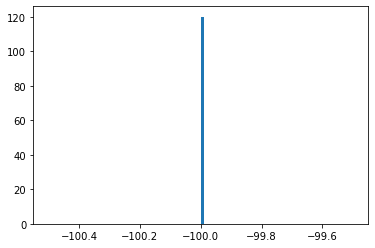

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11704844_2_2_2_float.hdf5


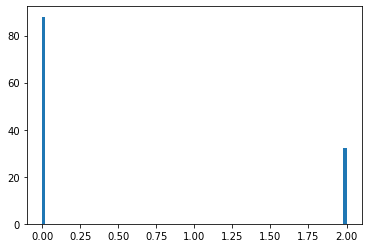

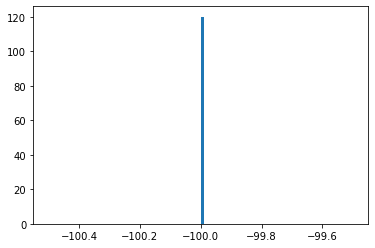

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16309713_3_2_1_float.hdf5


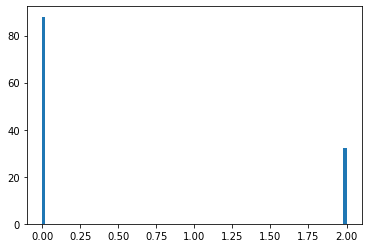

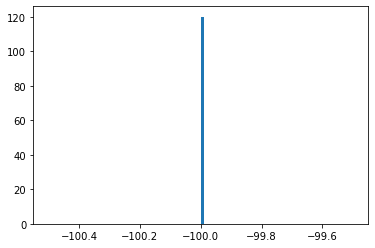

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4816619_0_2_3_float.hdf5


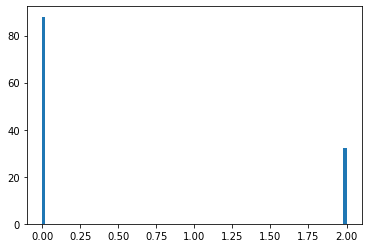

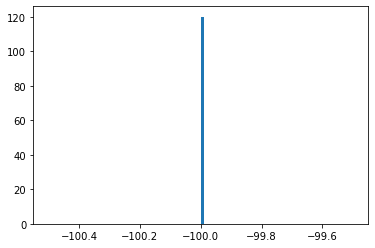

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2752172_3_3_0_float.hdf5


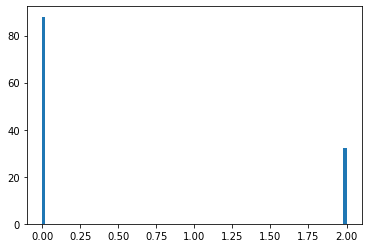

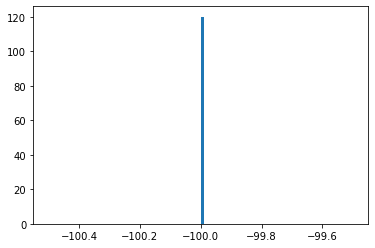

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6787589_3_1_0_float.hdf5


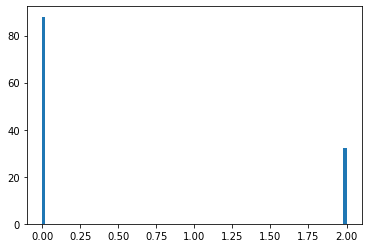

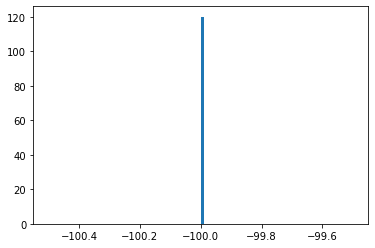

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a632302_3_3_2_float.hdf5


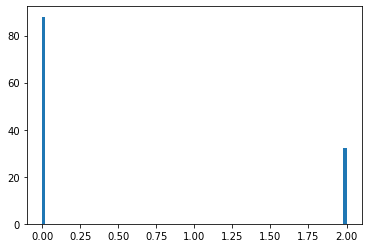

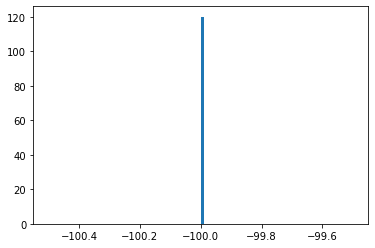

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14762792_2_1_3_float.hdf5


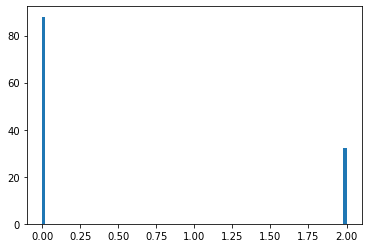

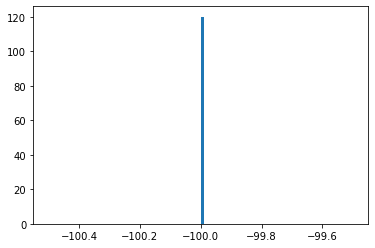

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2025313_2_1_1_float.hdf5


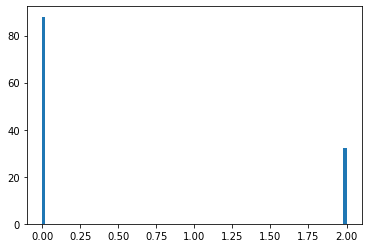

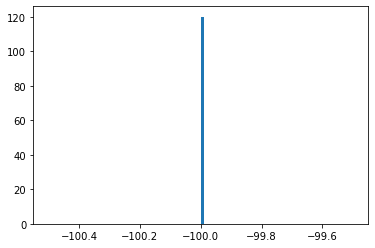

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3316329_1_2_0_float.hdf5


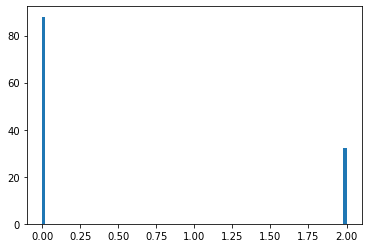

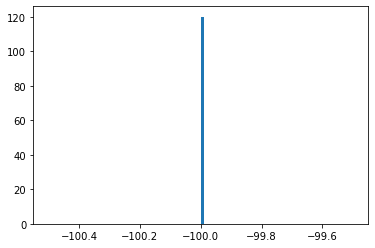

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3914995_0_3_3_float.hdf5


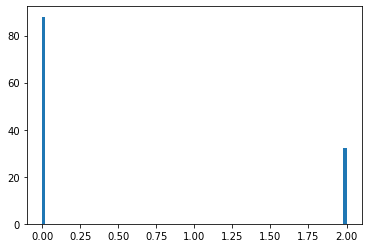

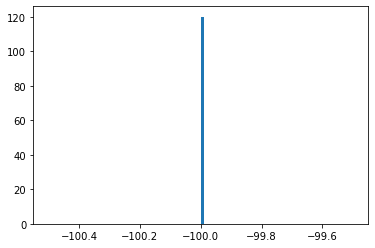

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11186604_0_0_2_float.hdf5


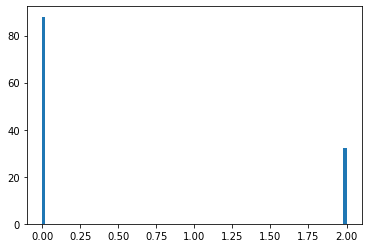

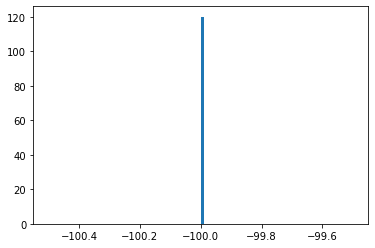

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6056190_2_1_0_float.hdf5


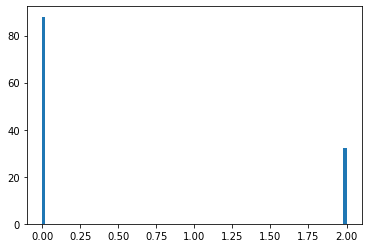

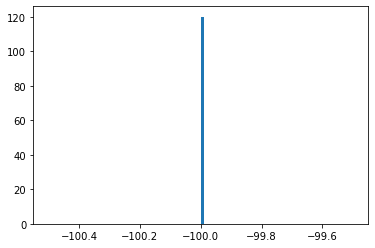

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10561248_0_3_3_float.hdf5


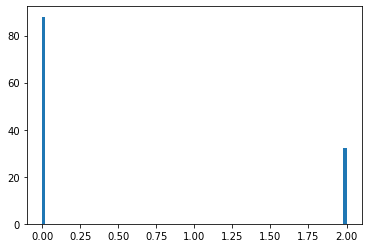

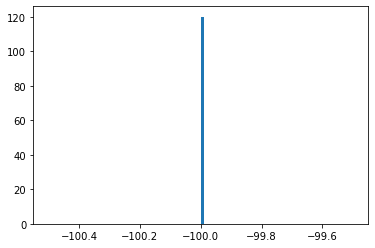

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11308040_0_2_0_float.hdf5


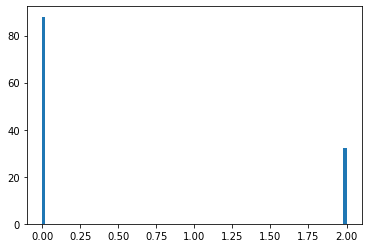

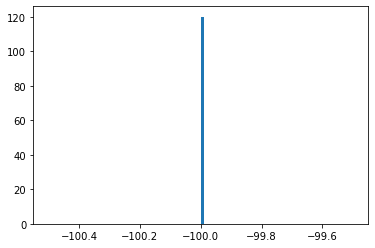

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13603078_3_0_1_float.hdf5


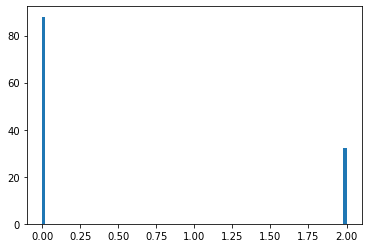

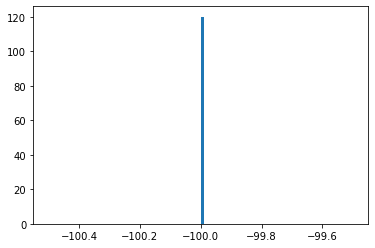

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4590862_0_0_0_float.hdf5


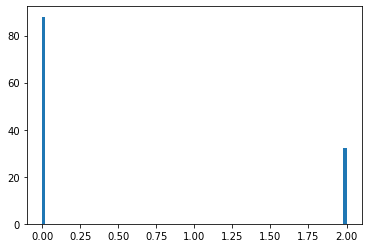

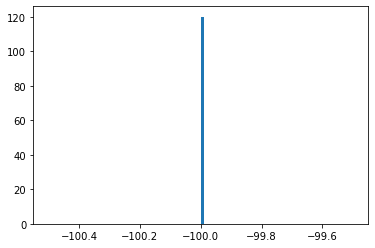

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5454879_2_2_1_float.hdf5


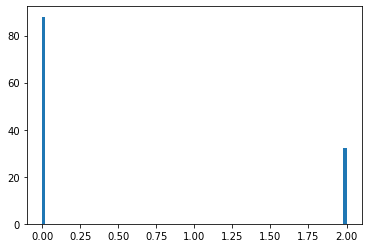

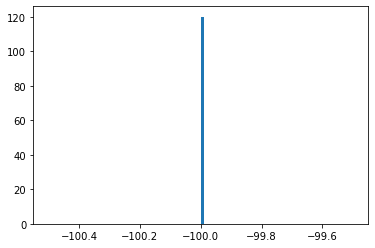

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3181200_1_0_0_float.hdf5


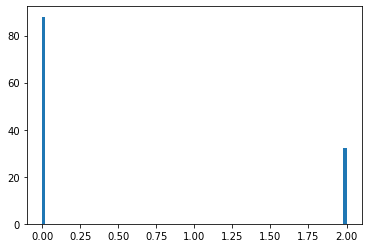

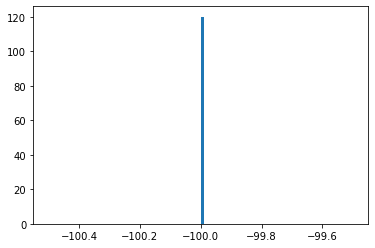

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3772937_1_2_3_float.hdf5


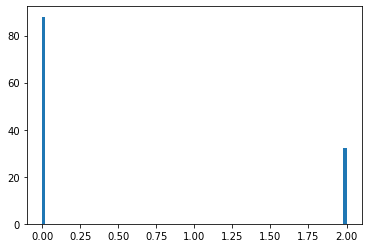

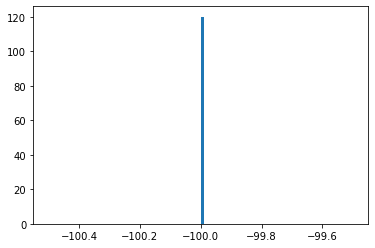

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3359618_0_2_0_float.hdf5


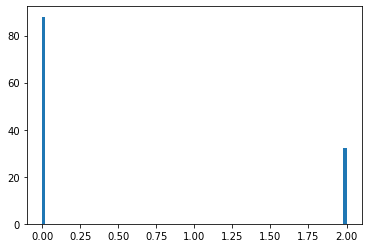

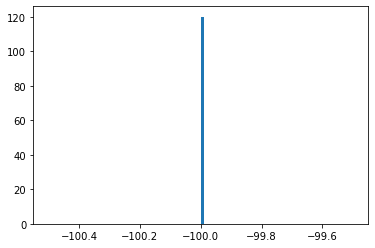

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5896376_3_0_2_float.hdf5


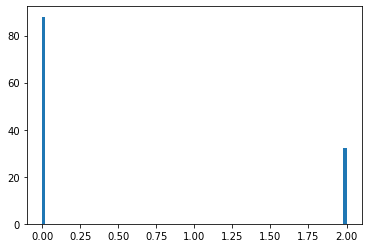

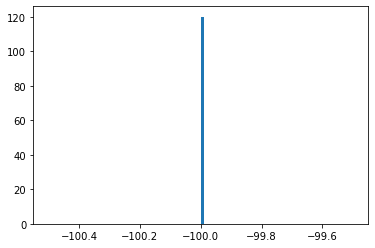

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13963975_3_1_1_float.hdf5


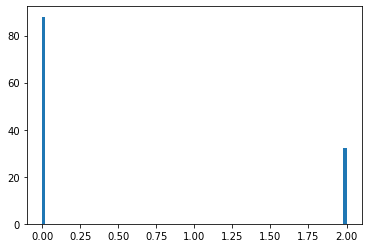

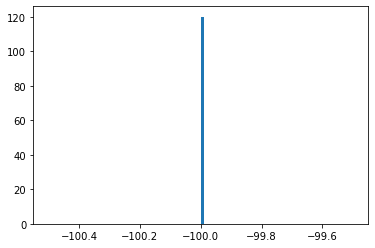

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2203550_0_1_0_float.hdf5


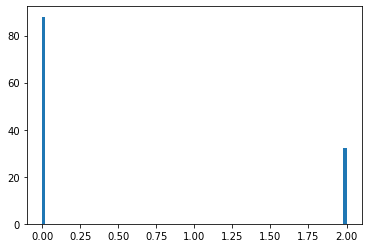

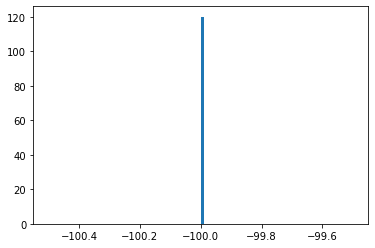

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5115575_1_2_0_float.hdf5


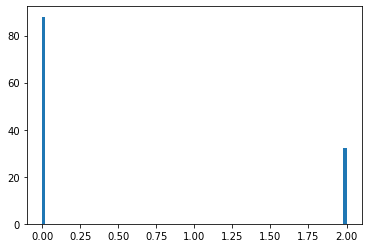

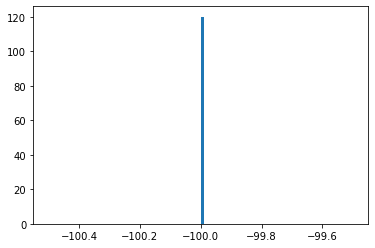

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13820975_1_0_2_float.hdf5


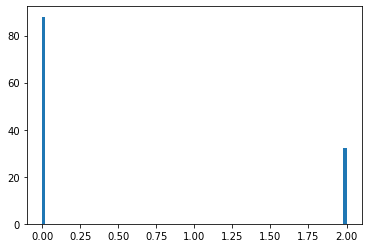

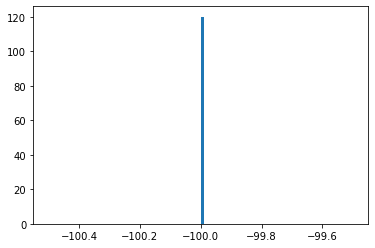

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12601317_1_3_3_float.hdf5


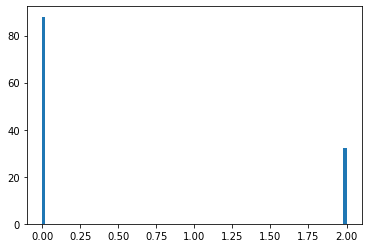

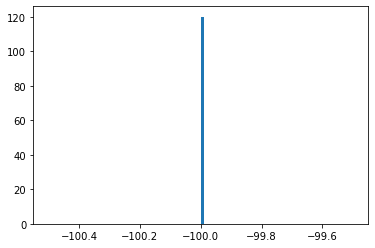

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13648773_3_2_3_float.hdf5


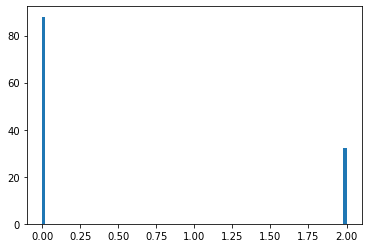

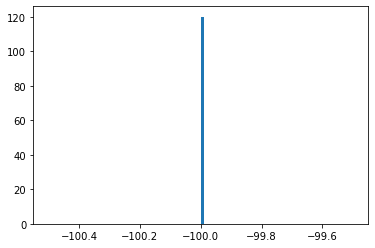

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a219451_0_2_0_float.hdf5


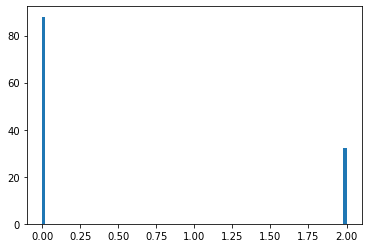

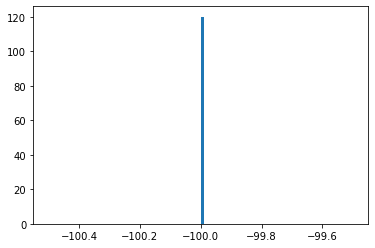

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a304164_1_3_2_float.hdf5


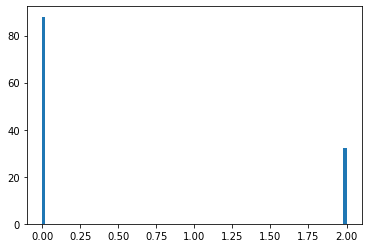

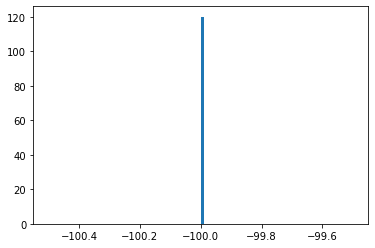

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13740356_2_0_2_float.hdf5


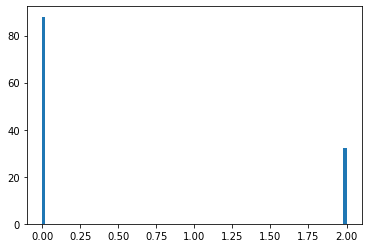

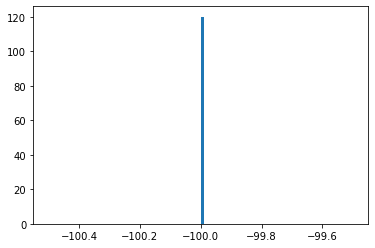

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5865399_1_0_0_float.hdf5


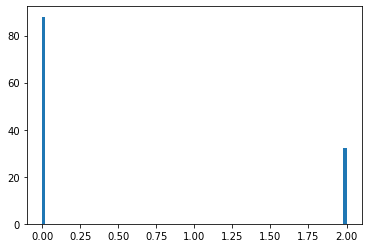

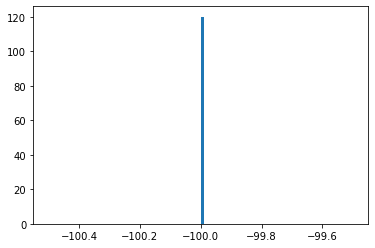

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a225267_0_3_3_float.hdf5


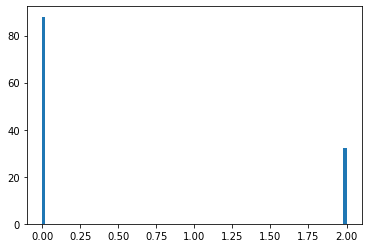

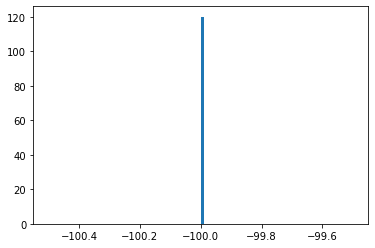

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14952133_1_0_3_float.hdf5


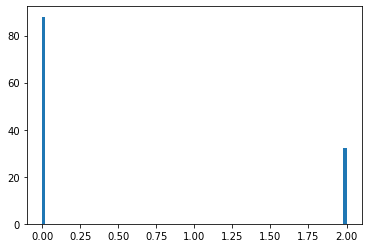

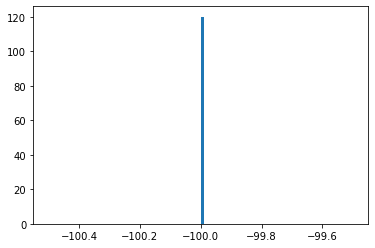

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11342595_0_2_2_float.hdf5


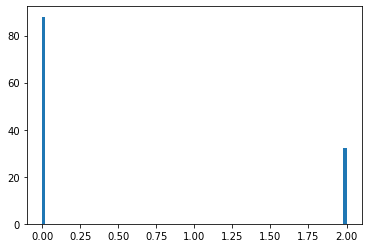

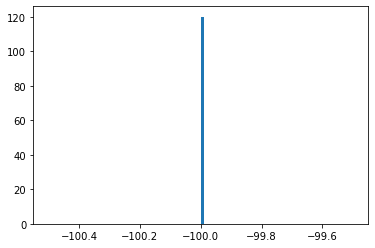

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1467470_1_0_1_float.hdf5


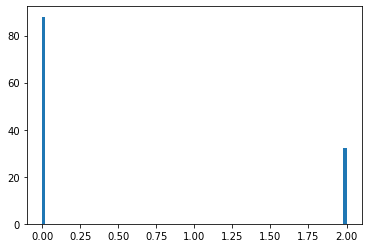

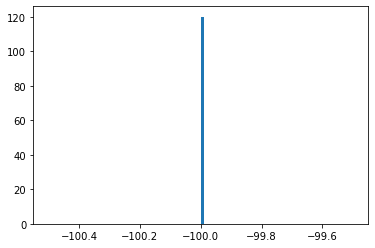

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a575362_1_0_3_float.hdf5


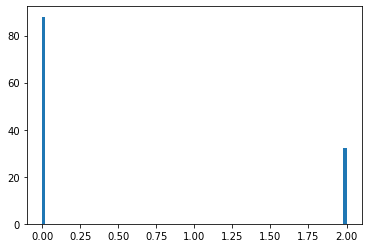

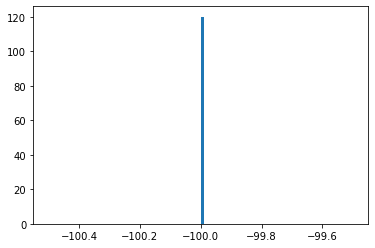

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12919236_3_3_1_float.hdf5


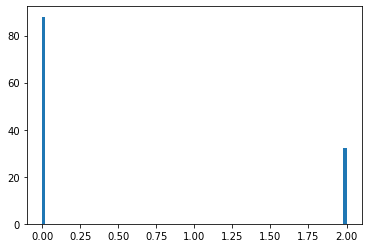

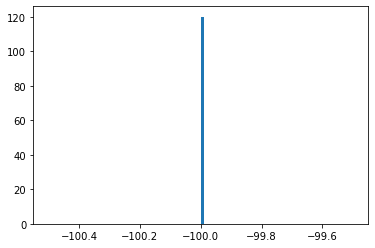

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2826561_1_3_0_float.hdf5


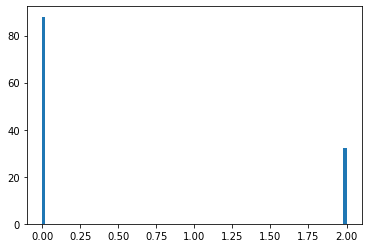

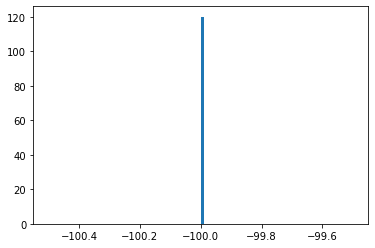

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1394481_2_1_1_float.hdf5


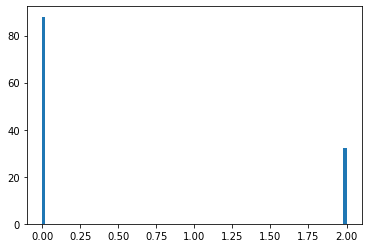

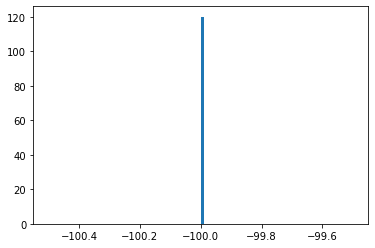

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13410444_0_3_3_float.hdf5


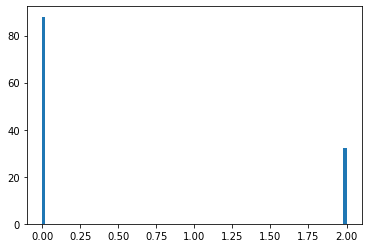

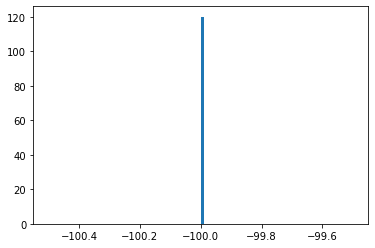

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15525074_3_0_3_float.hdf5


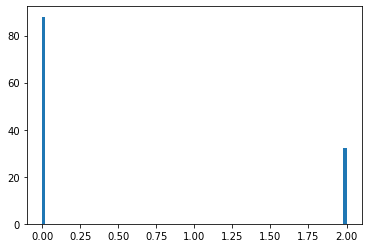

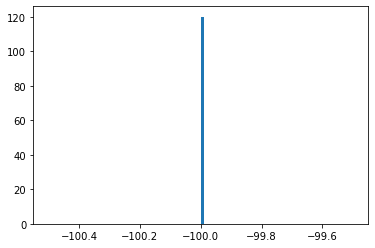

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1952275_3_3_1_float.hdf5


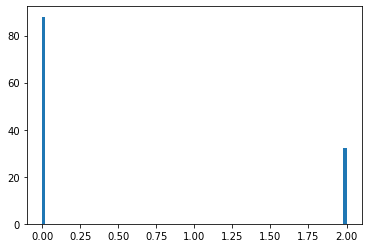

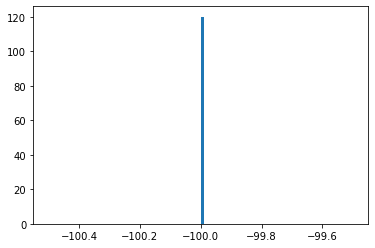

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3493074_2_2_3_float.hdf5


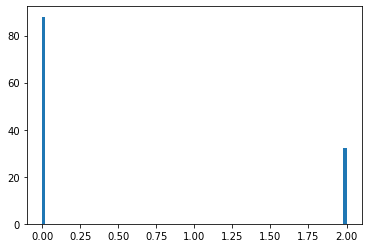

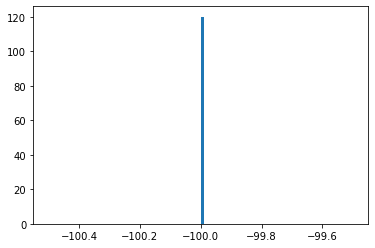

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a569234_1_2_0_float.hdf5


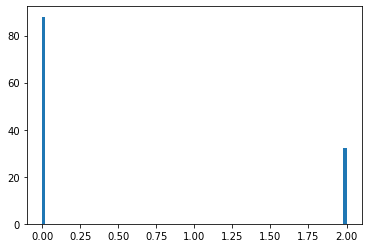

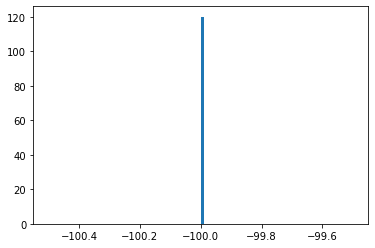

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2338487_1_0_0_float.hdf5


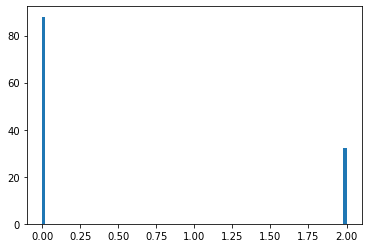

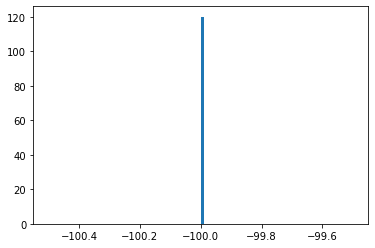

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1237123_1_3_1_float.hdf5


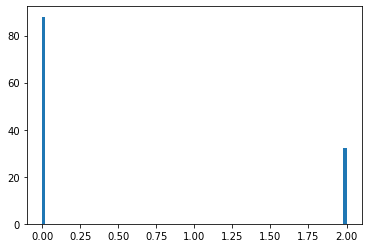

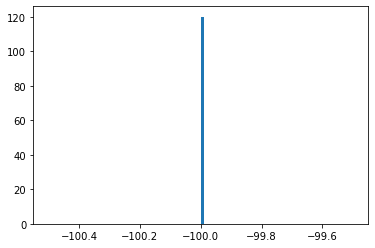

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5162648_0_3_0_float.hdf5


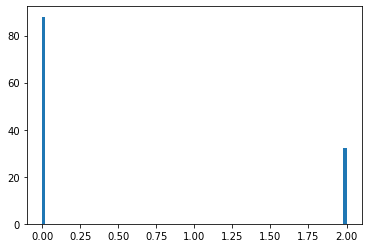

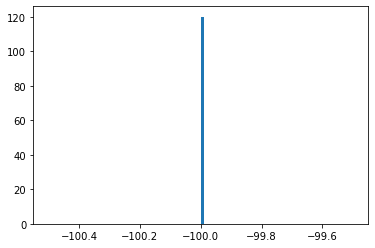

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2256120_2_1_3_float.hdf5


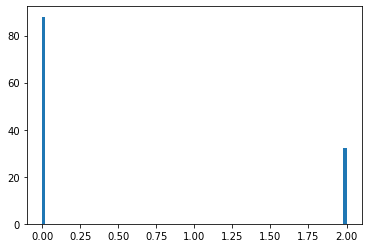

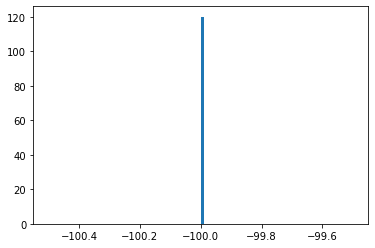

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13648380_0_2_2_float.hdf5


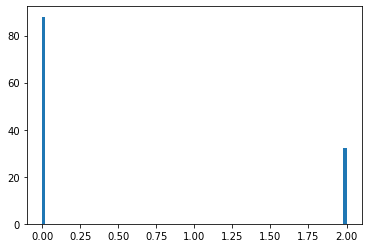

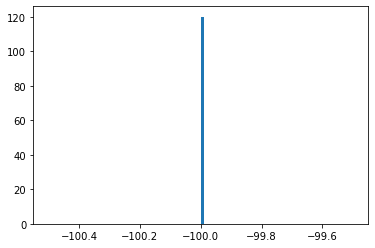

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5812185_0_1_1_float.hdf5


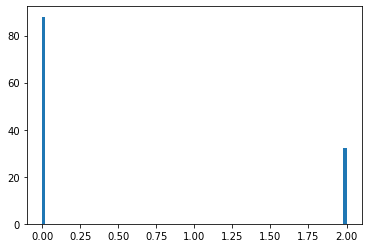

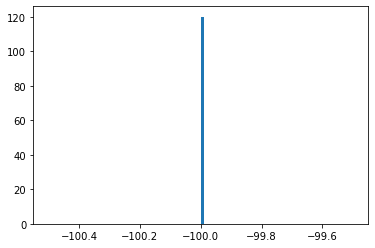

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12599127_2_1_1_float.hdf5


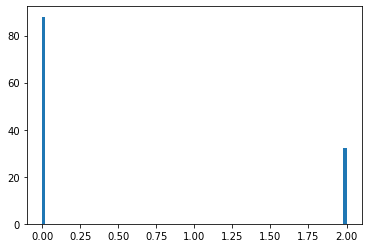

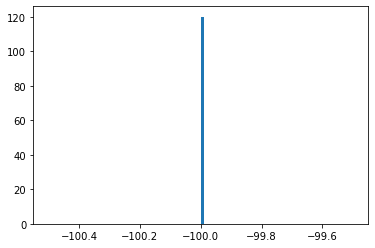

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13987358_1_1_2_float.hdf5


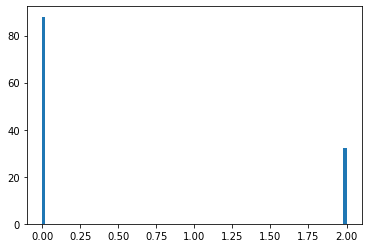

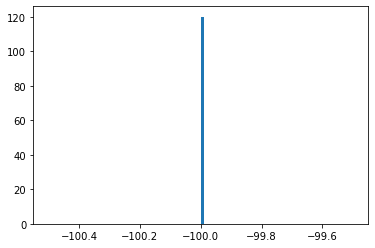

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14050184_2_0_0_float.hdf5


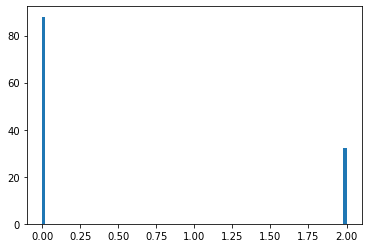

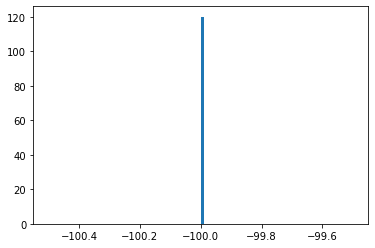

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6205346_2_3_0_float.hdf5


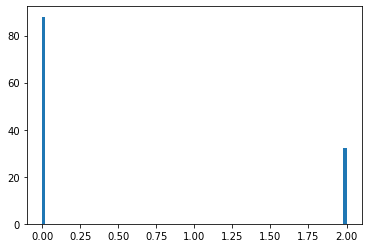

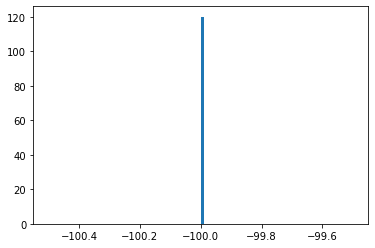

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15668119_2_1_2_float.hdf5


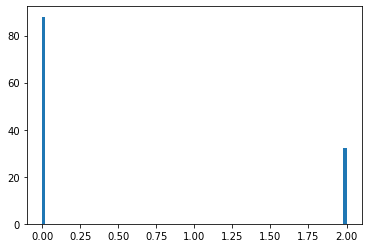

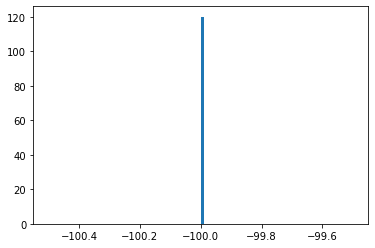

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16350594_2_3_0_float.hdf5


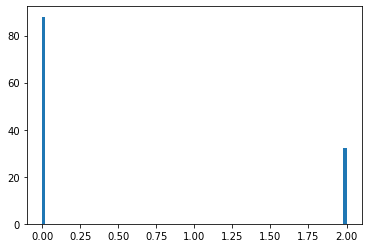

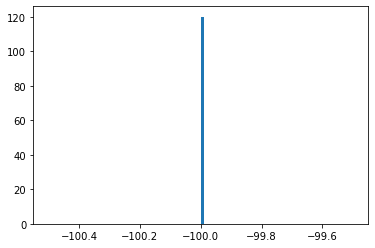

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14327480_0_3_0_float.hdf5


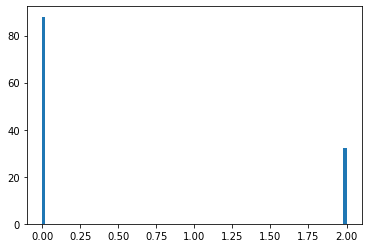

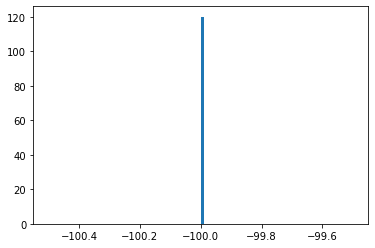

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15703137_1_3_1_float.hdf5


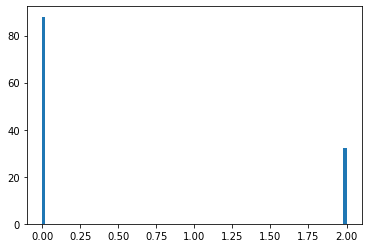

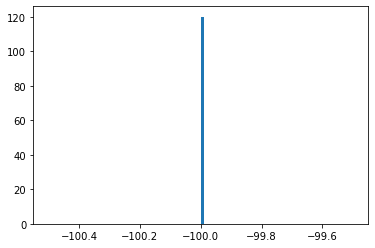

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6759352_2_0_0_float.hdf5


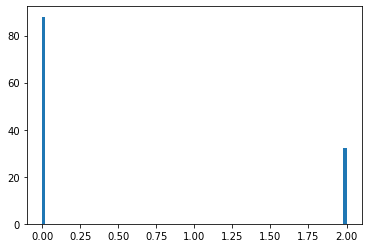

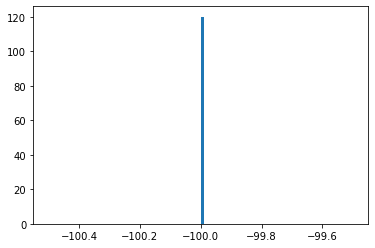

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3983207_0_0_1_float.hdf5


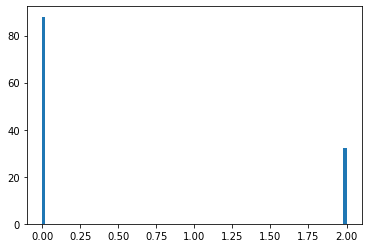

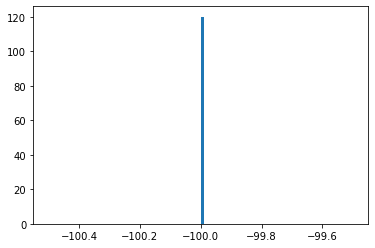

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15742467_0_3_0_float.hdf5


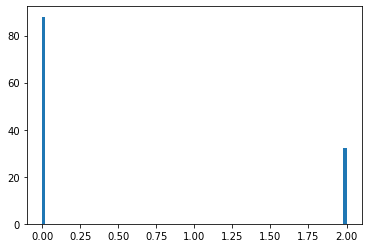

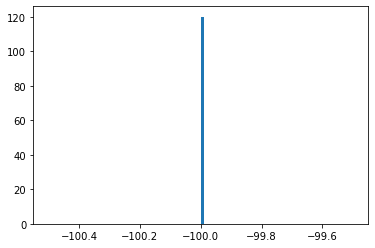

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2896311_1_0_2_float.hdf5


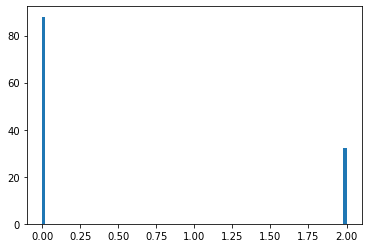

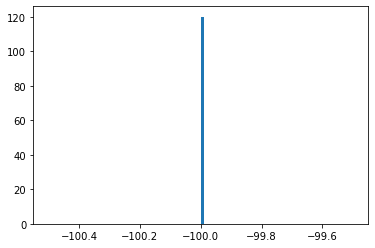

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13072577_3_0_0_float.hdf5


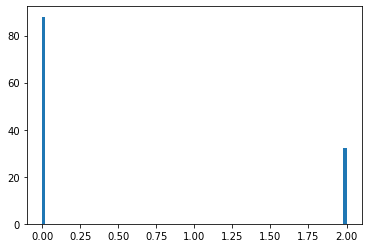

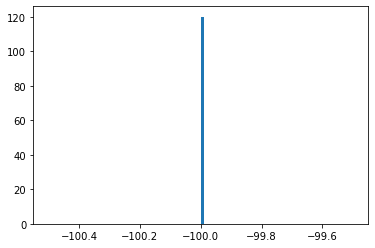

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16032095_1_0_3_float.hdf5


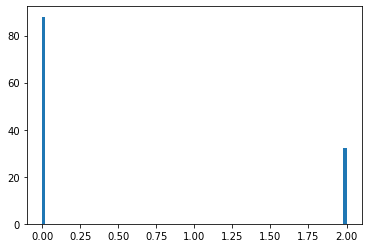

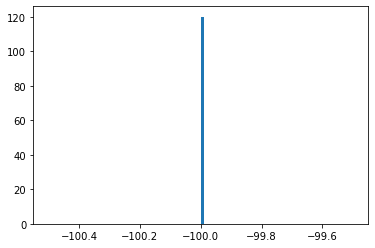

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13076291_1_0_2_float.hdf5


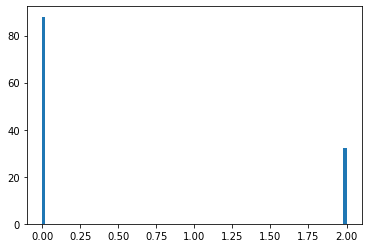

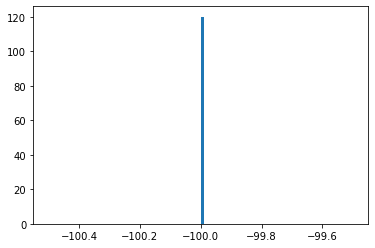

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14320770_0_2_1_float.hdf5


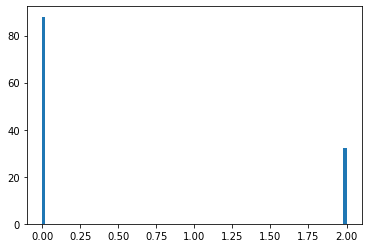

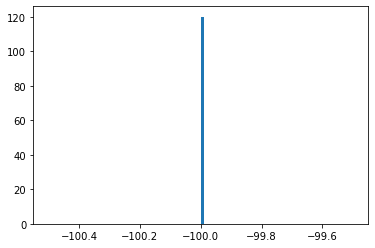

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4858348_3_3_2_float.hdf5


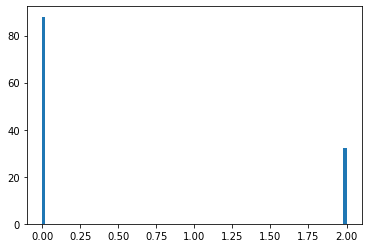

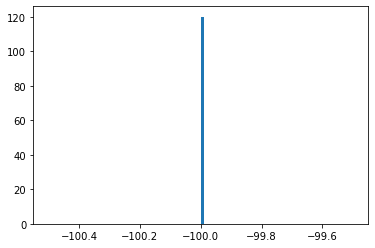

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14663059_3_1_2_float.hdf5


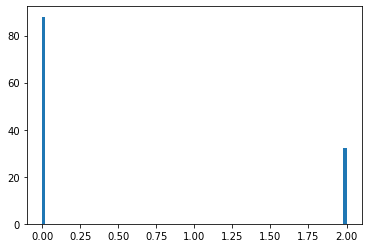

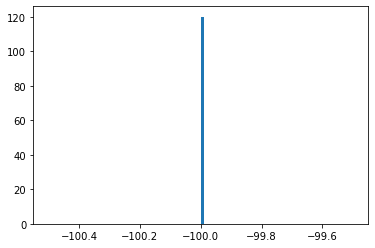

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4251558_2_1_0_float.hdf5


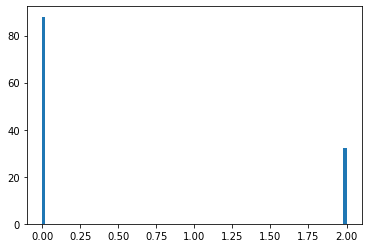

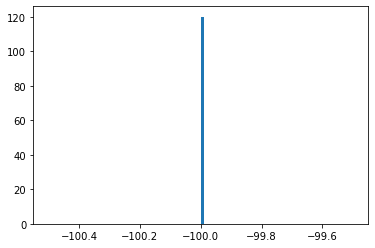

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13104263_3_0_2_float.hdf5


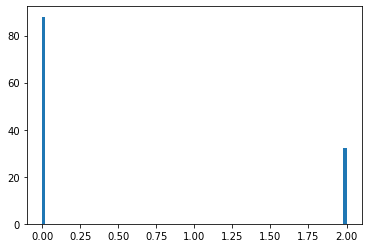

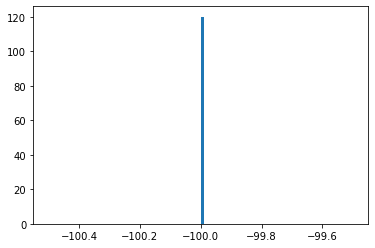

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13192112_0_1_2_float.hdf5


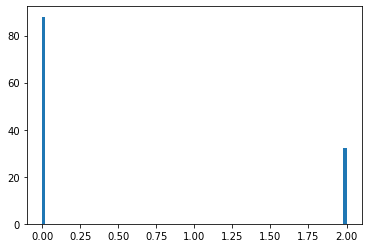

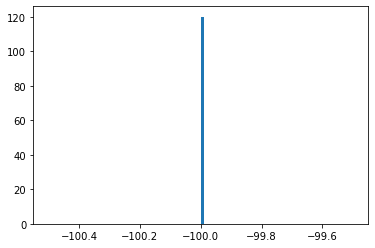

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11167052_3_3_0_float.hdf5


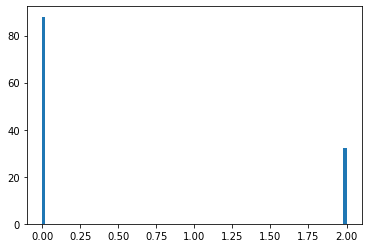

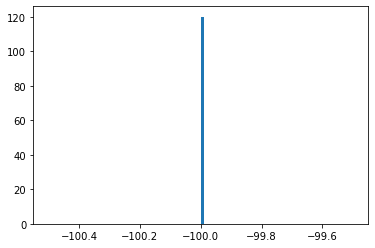

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3956025_2_2_0_float.hdf5


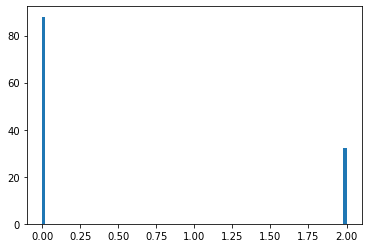

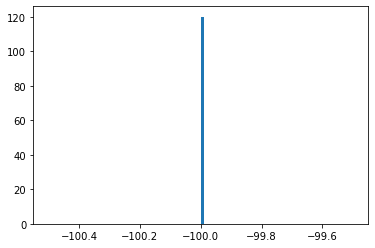

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15575936_0_0_2_float.hdf5


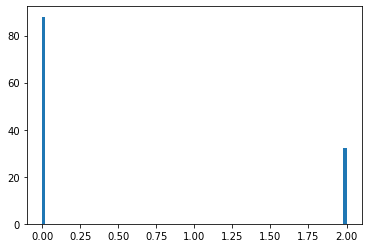

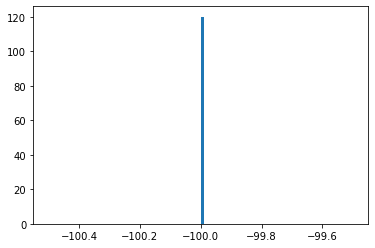

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a16175495_0_1_1_float.hdf5


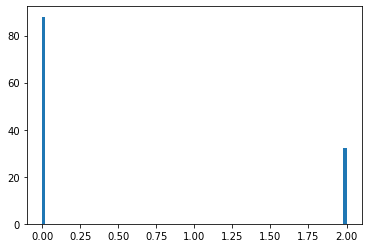

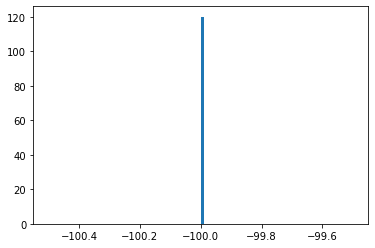

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a12957905_1_2_3_float.hdf5


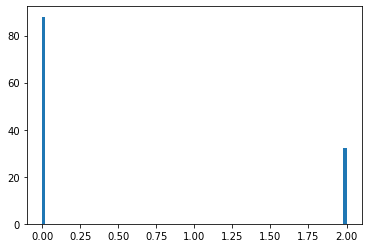

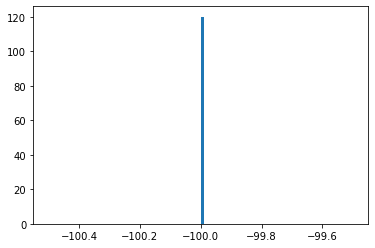

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2651393_3_1_3_float.hdf5


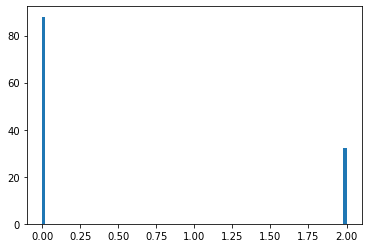

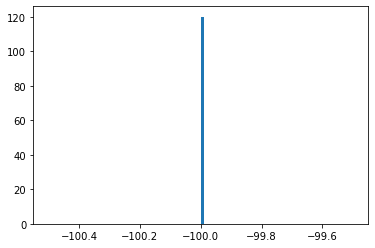

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11352060_3_0_0_float.hdf5


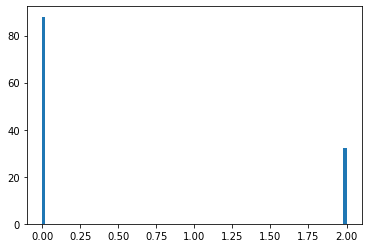

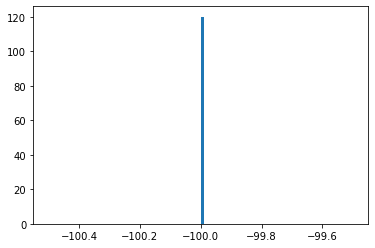

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a15854685_3_1_3_float.hdf5


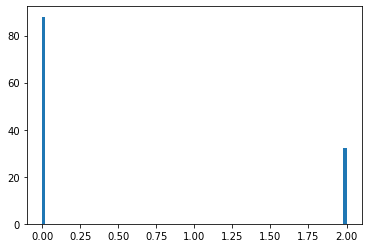

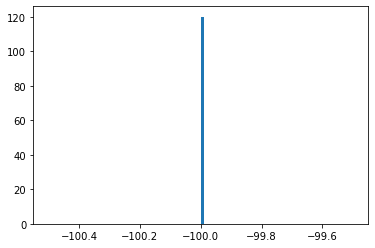

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a2608229_3_1_0_float.hdf5


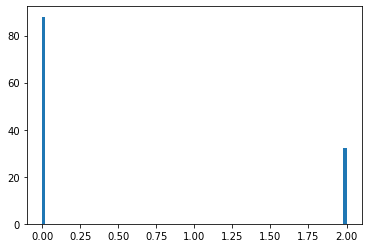

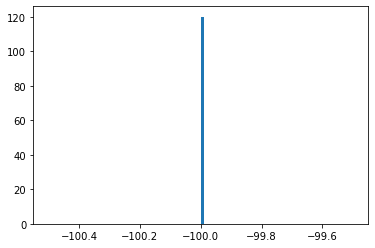

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a14076612_0_3_2_float.hdf5


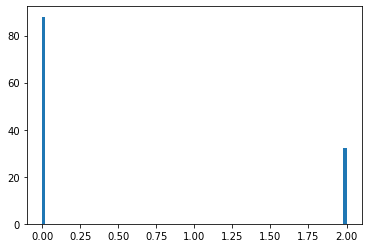

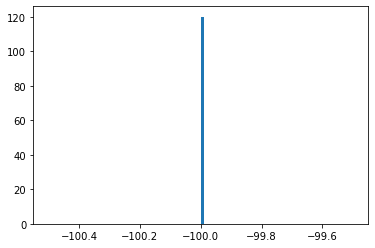

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a618182_1_1_3_float.hdf5


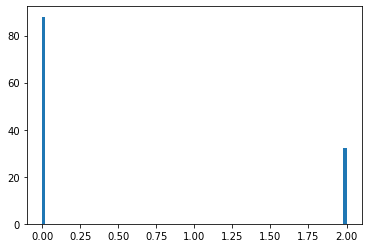

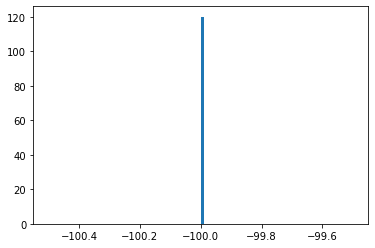

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4635720_1_0_0_float.hdf5


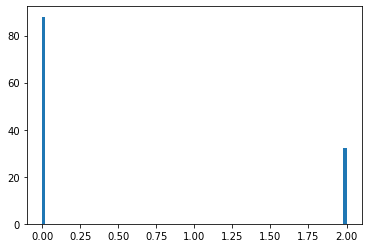

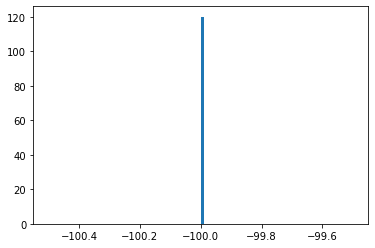

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10523843_1_0_0_float.hdf5


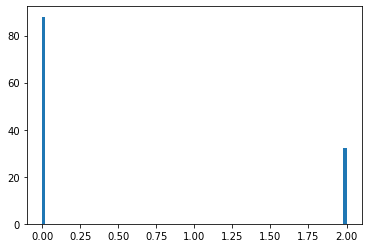

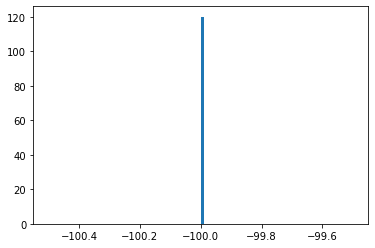

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3428292_0_0_2_float.hdf5


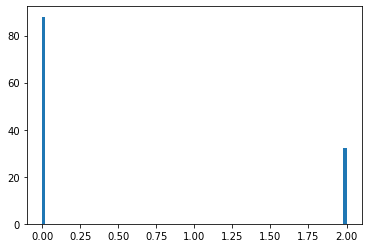

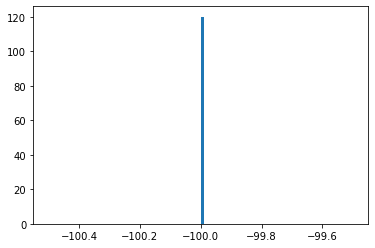

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1869090_1_0_2_float.hdf5


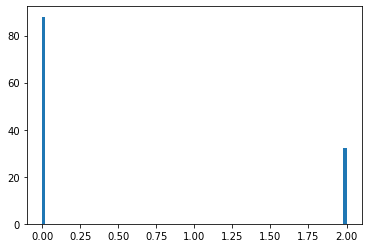

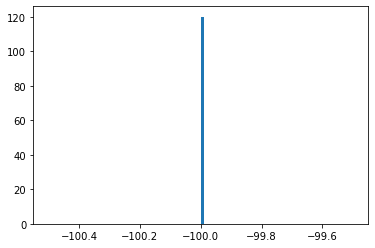

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13240807_2_3_1_float.hdf5


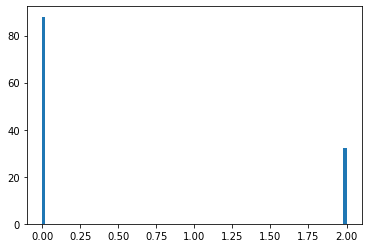

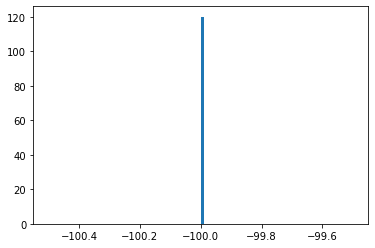

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a3427730_2_1_1_float.hdf5


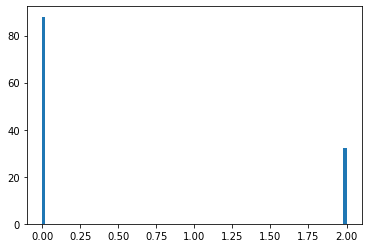

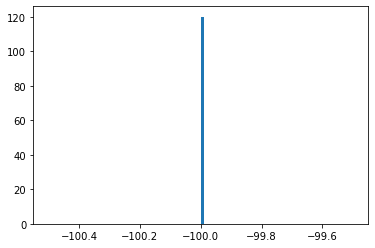

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5282805_1_0_0_float.hdf5


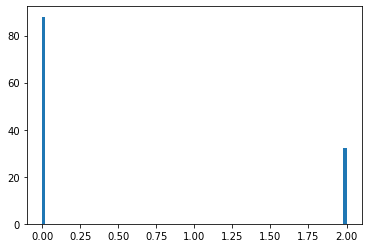

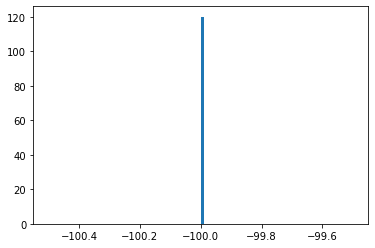

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a13240741_1_2_1_float.hdf5


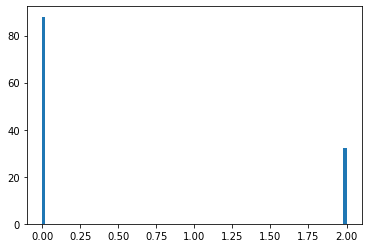

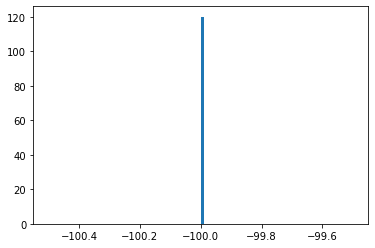

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a1383383_0_3_1_float.hdf5


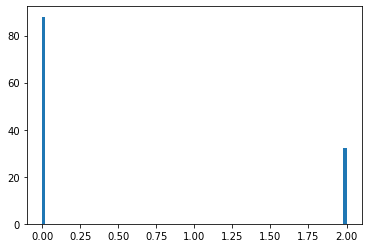

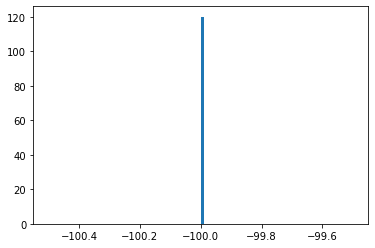

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a5411046_2_1_3_float.hdf5


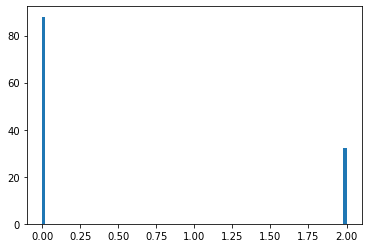

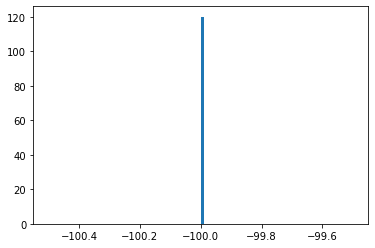

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10296001_2_0_3_float.hdf5


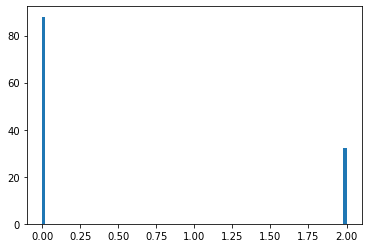

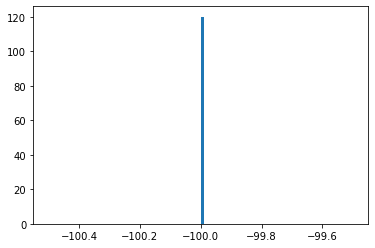

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4256417_3_1_0_float.hdf5


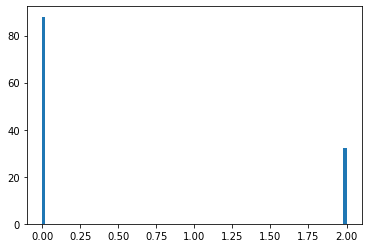

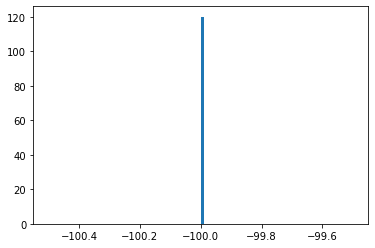

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a6136947_2_2_2_float.hdf5


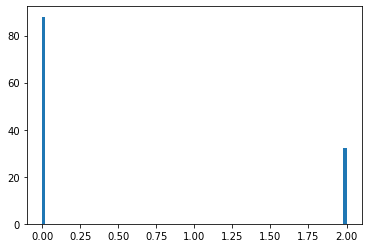

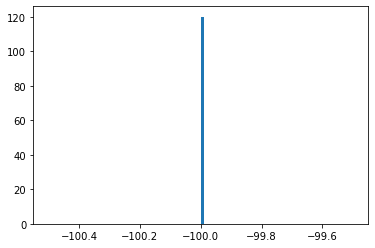

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10690500_1_3_0_float.hdf5


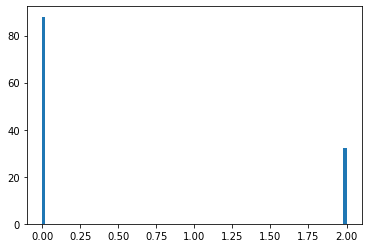

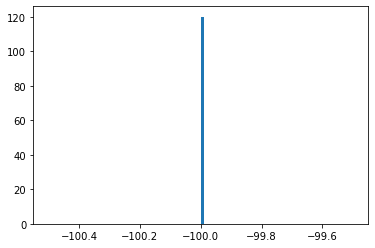

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a4819276_2_3_3_float.hdf5


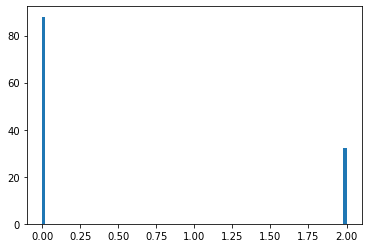

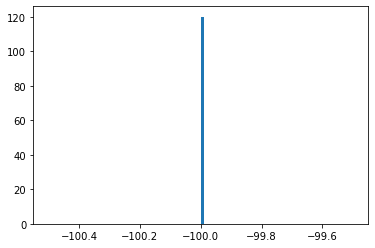

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a10251128_1_2_3_float.hdf5


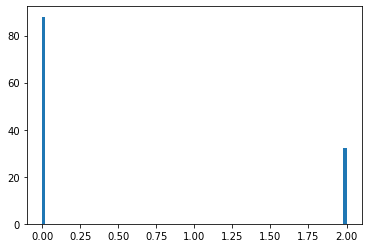

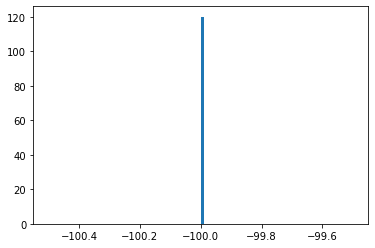

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11133624_2_3_1_float.hdf5


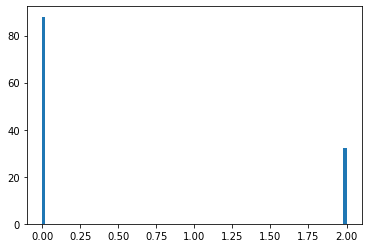

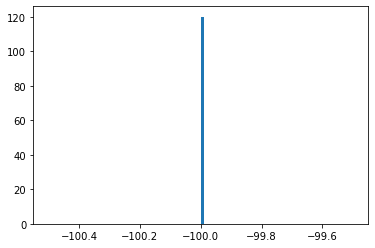

/p/gpfs1/brainusr/datasets/cosmoflow/cosmoUniverse_2019_05_4parE/hdf5_transposed_dim128_float/all/univ_ics_2019-03_a11738197_3_1_3_float.hdf5


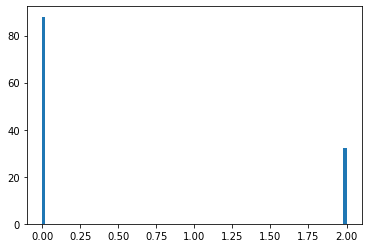

In [ ]:
for filename in relevant_filenames:
    print(filename)
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'], bins=100)
    plt.show()